# E-Commerce Shipment Perspective & Prediction
# Project Background
Currently, our e-commerce On-Time Delivery Rate in this dataset is only 40%.

In the world of e-commerce, on-time delivery is essential for customer satisfaction, where 32%
of customers complain about late delivery, according to the results of a survey titled [“Biggest
Drawbacks of E-Commerce Purchases (Worldwide, 2022)” by Koen van Gelder via Statista](https://www.statista.com/statistics/1308184/online-shopping-drawbacks-worldwide/).
The survey also confirms that late delivery is **one of the four major problems** faced by
e-commerce users.

We will focus on the **On-Time Delivery Rate** as the main business metric.

People involved in this project:
1. [Atthoriq Putra Pangestu (Team Lead)](https://www.linkedin.com/in/atthoriqputra/)
2. [Alvida Dwiki Chairunnisa](https://www.linkedin.com/in/alvidadwikic/)
3. [Darell Timothy Tarigan](https://www.linkedin.com/in/darell-timothy-tarigan-533238247/)
4. [Emir Akbar](https://www.linkedin.com/in/emir-akbar-7b69b0260/)
5. [Nur Baiti Listyaningrum](https://www.linkedin.com/in/nur-baiti-listyaningrum/)
6. [Reny Rafiqah](https://www.linkedin.com/in/reny-rafiqah-41b050103/)

# Environment and Dataset Preparation
Before we begin exploring the dataset, let's prepare the dataset and libraries required for this project.

In [1]:
# Install the SHAP package
!pip install shap

In [2]:
# Data manipulation library
import numpy as np
import pandas as pd

# Data visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
import scipy.stats as st
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RandomizedSearchCV

import shap

# Hide warnings
import warnings 
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('/kaggle/input/customer-analytics/Train.csv')

# EDA

## Descriptive Analysis
Let's first quickly inspect the data types that each of our feature has.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


The following changes will be made for visualization purposes:

- `ID` is more suitable in a different data format: object.
- `Reached.on.Time_Y.N` (target) is more suitable in a different data format: object (because the model used is classification).
- `Customer_rating` should be in a different data format: object.
- The target `Reached.on.Time_Y.N` needs to be renamed to `Delivery_status` to make it easier to use:
    - 0 --> On time
    - 1 --> Late
- The other columns seem appropriate.

In [5]:
# Changing ID to an object
df['ID'] = df['ID'].astype('str')

# Changing Customer_rating to object
df['Customer_rating'] = df['Customer_rating'].astype('str')

# Changing target variable Reached.on.Time_Y.N to object
df['Reached.on.Time_Y.N'] = df['Reached.on.Time_Y.N'].astype('str')

# Renaming target name
df.rename(columns = {'Reached.on.Time_Y.N' : 'Delivery_status'}, inplace = True)

# Showing the changes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  object
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  object
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Delivery_status      10999 non-null  object
dtypes: int64(5), object(7)
memory usage: 1.0+ MB


After that, we can check the number of missing values that each feature has.

In [6]:
# Double check the missing values
df.isnull().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Delivery_status        0
dtype: int64

Observation result:
- There are no missing values across all columns.

What about duplicates?

In [7]:
# Checking for duplicates
print(f'Duplicate observations: {df.duplicated().sum()}')

Duplicate observations: 0


Observation result:
- There are no duplicates in data

Now let's go inspect the summary statistics for numerical data first.

In [8]:
# Numerical summary statistics
df.describe()

,Customer_care_calls,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,4.054459,210.196836,3.567597,13.373216,3634.016729
std,1.141490,48.063272,1.522860,16.205527,1635.377251
min,2.000000,96.000000,2.000000,1.000000,1001.000000
25%,3.000000,169.000000,3.000000,4.000000,1839.500000
50%,4.000000,214.000000,3.000000,7.000000,4149.000000
75%,5.000000,251.000000,4.000000,10.000000,5050.000000
max,7.000000,310.000000,10.000000,65.000000,7846.000000


Observation results:
- The `Discount_offered` variable indicate a right-skewed distribution (Need to confirm later on with histograms), high variance, and potential outlier based on the max and 75% percentile distance
- `Prior_purchases` variable has potential outliers
- `Weight_in_gms` variable indicate a left-skewed distribution
- Other columns looks 'normal' enough based on their numbers

Then, let's move on to the categorical data summary statistics.

In [9]:
# Categorical summary statistics
df.describe(include = 'object').drop(columns = 'ID')

,Warehouse_block,Mode_of_Shipment,Customer_rating,Product_importance,Gender,Delivery_status
count,10999,10999,10999,10999,10999,10999
unique,5,3,5,3,2,2
top,F,Ship,3,low,F,1
freq,3666,7462,2239,5297,5545,6563


Observation results:
- Most products (about 68%) are delivered using the ship method.
- Most deliveries are late (about 60%).
- All columns seem fine based on their numbers (no strange or catchy values).

## Univariate Analysis
First thing first, we're going to explore the features individually, inspecting their distributions. Before diving further, let's create two variables that will separate categorical and numerical variables

In [10]:
# Separating between categorical and numerical data
cats = df.select_dtypes(include = 'object').columns.tolist()
nums = df.select_dtypes(exclude = 'object').columns.tolist()

Because we will not use the `ID` variable, we'll remove it from the list of categoricals

In [11]:
# Removing the ID variable from categoricals
cats = cats[1:]

Now, let's check the distribution of numerical features using a box plot.

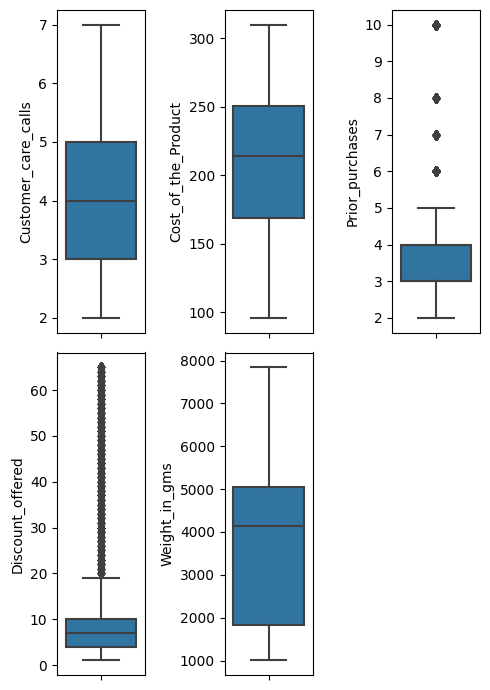

In [12]:
# Checking the distribution of each numerical column with a boxplot
plt.figure(figsize = (5, 7))

for i in range (0, len(nums)):
  plt.subplot(2,3, i+1)
  sns.boxplot(y=df[nums[i]], orient = 'v')

plt.tight_layout()

Observation results:

- The numerical features that has outliers are `Prior_Purchases` and `Dicount_offered`.
- The `Discount_offered` feature has the most outliers.
- No outliers found in other features.

We can further check the distribution using a histogram.

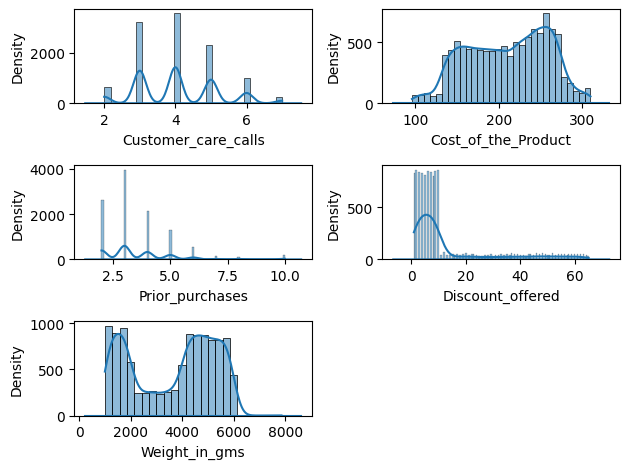

In [13]:
# Checking the distribution of each numerical column with histogram
for i in range (0, len(nums)):
  plt.subplot(3,2, i+1)
  sns.kdeplot(x=df[nums[i]])
  sns.histplot(kde = True, x = df[nums[i]])
  plt.tight_layout()

Observation results:
- The `Cost_of_the_product` distribution is approximately normal
- `Weight_in_gms` feature have a bimodal distribution.
- The `Discount_offered` feature has a positively skewed distribution.

The following variables contains discrete values and needed their own bins to be shown appropriately:
- `Customer_care_calls`
- `Prior_purchases`

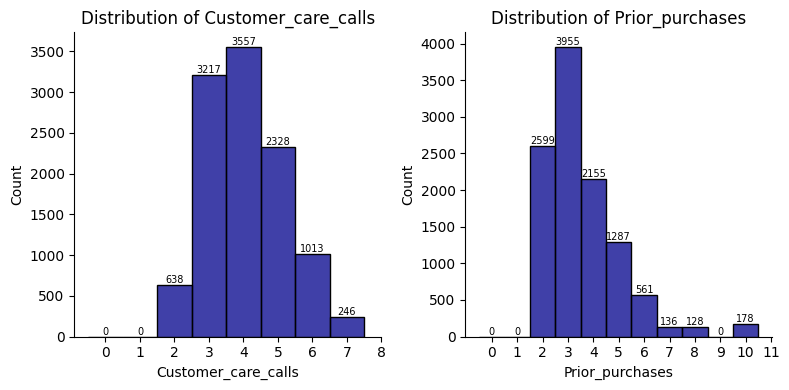

In [14]:
custom_bins = ['Customer_care_calls', 'Prior_purchases']
plt.figure(figsize = (8, 4))

for i in range(0, len(custom_bins)):
    bins = np.arange(0, df[custom_bins[i]].max() + 1.5) - 0.5
    plt.subplot(1, 2, i + 1)
    ax = sns.histplot(x = df[custom_bins[i]], bins = bins, color = 'darkblue')
    plt.xticks(bins + 0.5)
    sns.despine(right = True)
    plt.bar_label(ax.containers[0], label_type = 'edge', fontweight = 'normal', size = 7)
    plt.title(f'Distribution of {custom_bins[i]}')

plt.tight_layout()
plt.show()

Observation results:

- The `Customer_care_calls` feature has a normal distribution, The highest customer care calls is at 4 calls with 3557 customers.
- The `Prior_purchases` feature has a positively skewed distribution, the highest `Prior_purchases` is at 3 prior purchases with 3955 customers.

We can additionally check the skewness in numbers here.

In [15]:
# Skewness in numbers
df.skew(numeric_only = True).sort_values(ascending = False)

Discount_offered       1.798929
Prior_purchases        1.681897
Customer_care_calls    0.391926
Cost_of_the_Product   -0.157117
Weight_in_gms         -0.249747
dtype: float64

We can further confirm that the following features have skewed distribution:
1. `Discount_offered`
2. `Prior_purchases`

Then, let's check the distribution of values across categorical features.

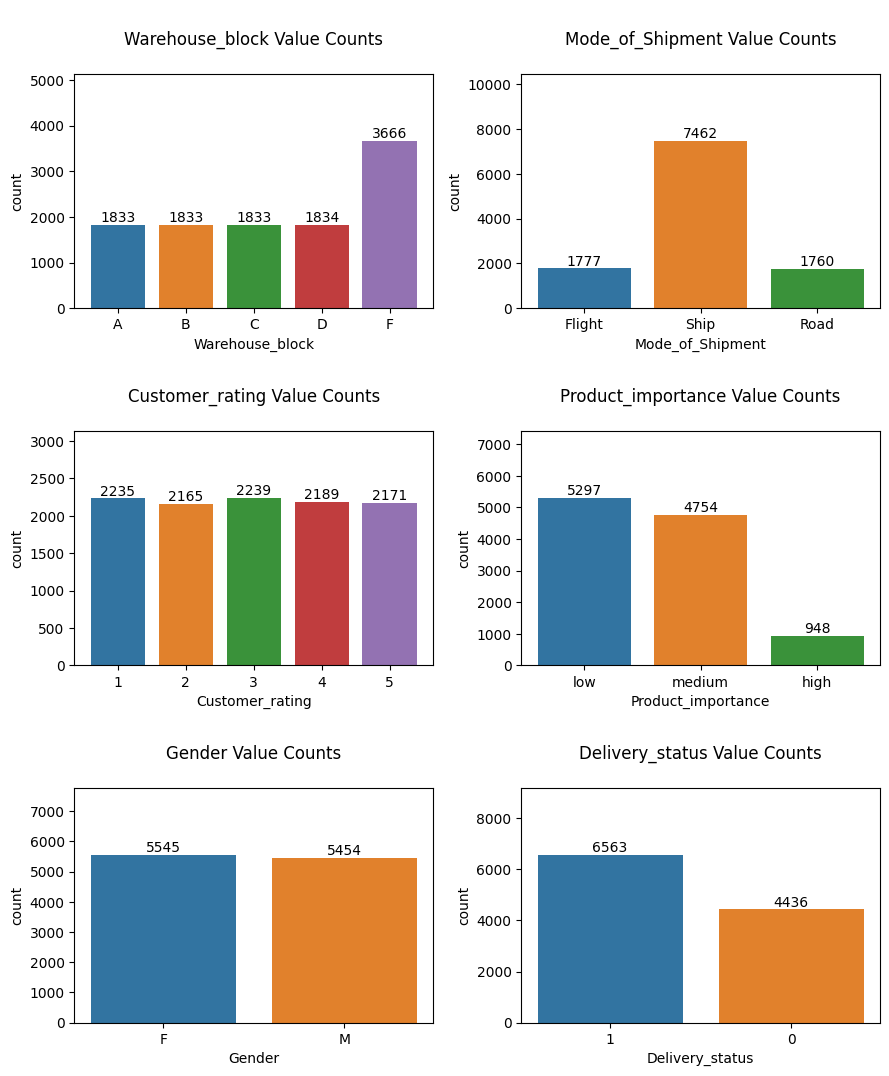

In [16]:
plt.figure(figsize = (9, 14))
plotnumber = 1

for i in range(len(cats)):
    if plotnumber <= 8:
        if cats[i] == 'Warehouse_block':
            ax = plt.subplot(4, 2, plotnumber)
            sns.countplot(x = cats[i], data = df , ax = ax, order = sorted(df['Warehouse_block'].unique().tolist()))
            plt.bar_label(ax.containers[0], label_type = 'edge', fontweight = 'normal')
            plt.title(f"\n{cats[i]} Value Counts\n", fontsize = 12)
            plt.margins(x = 0.05, y = 0.4)
        elif cats[i] == 'Customer_rating':
            ax = plt.subplot(4, 2, plotnumber)
            sns.countplot(x = cats[i], data = df , ax = ax, order = sorted(df['Customer_rating'].unique().tolist()))
            plt.bar_label(ax.containers[0], label_type = 'edge', fontweight = 'normal')
            plt.title(f"\n{cats[i]} Value Counts\n", fontsize = 12)
            plt.margins(x = 0.05, y = 0.4)
        else:
            ax = plt.subplot(4, 2, plotnumber)
            sns.countplot(x = cats[i], data = df , ax = ax)
            plt.bar_label(ax.containers[0], label_type = 'edge', fontweight = 'normal')
            plt.title(f"\n{cats[i]} Value Counts\n", fontsize = 12)
            plt.margins(x = 0.05, y = 0.4)
    plotnumber += 1

plt.tight_layout()
plt.show()

Observation results:
- Most shipments comes from `Warehouse_block` F.
  - Strangely, warehouse block E is missing from the data
- Based on the `Mode_of_Shipment`, the majority of order is delivered using the ship method.
- `Product_importance` shows that the most shipments are "Low", followed by "Medium" and the least are "High".
- There are fewer on time deliveries (4436) than late deliveries (6563) based on the `Delivery_status` feature.
- The distribution of values inside `Customer_rating` and `Gender` is similar (no dominant values).

## Multivariate Analysis
After getting a sense of each features' distributions, we can now inspect the relationship between each features, especially to find a meaningful relationship between featues and our target variable (`Delivery_status`).

### Numerical Features vs. Target
#### Correlation Heatmap

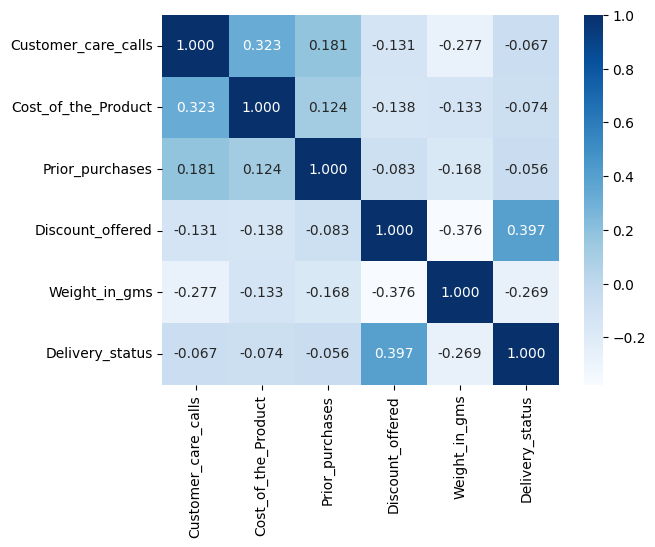

In [17]:
# Excluding the ID from correlation
df_corr = df.drop(columns = 'ID')

# Changing the `Delivery_status` temporary for showing correlation
df_corr['Delivery_status'] = df_corr['Delivery_status'].astype('int')

# Correlation heatmap
sns.heatmap(df_corr.corr(numeric_only = True), cmap = 'Blues', annot = True, fmt = '.3f')
plt.show()

Observation results:
- `Discount_offered` has moderate positive relationship with our target (r = 0.4), meaning that higher discount lead to higher probability of late deliveries. This feature may need to be retained for modeling.
- `Weight_in_gms` has weak negative relationship with our target (r = -0.27), meaning that the heavier a product is, the higher the probability of late deliveries. This feature may need to be retained for modeling.

As for features vs. features, the correlation doesn't show any strong relationships (above 0.8). Let's investigate further using VIF

#### Multicollinearity Check with VIF

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Independent variables set
X = df[nums]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

vif_data.sort_values('VIF', ascending = False)

,feature,VIF
1,Cost_of_the_Product,16.729226
0,Customer_care_calls,13.312730
2,Prior_purchases,6.238112
4,Weight_in_gms,4.482598
3,Discount_offered,1.605862


Generally, VIF above 10 means that particular variable can't be used for modelling and the multicollinearity is severe. As we can see from the above results, we have several features that will cause multicollinearity problem, namely:
1. `Cost_of_the_Product`
2. `Customer_care_calls`

To determine which one to remove, we'll compare their strength to the target variable, `Delivery_status`:
1. `Cost_of_the_Product` = -0.074
2. `Customer_care_calls` = -0.067

Because `Customer_care_calls` have multicollinearity problem and weaker correlation with the target, we'll drop `Customer_care_calls` later in the preprocessing stage

Let's continue the multivariate exploration with a pair plot

#### Pair Plot

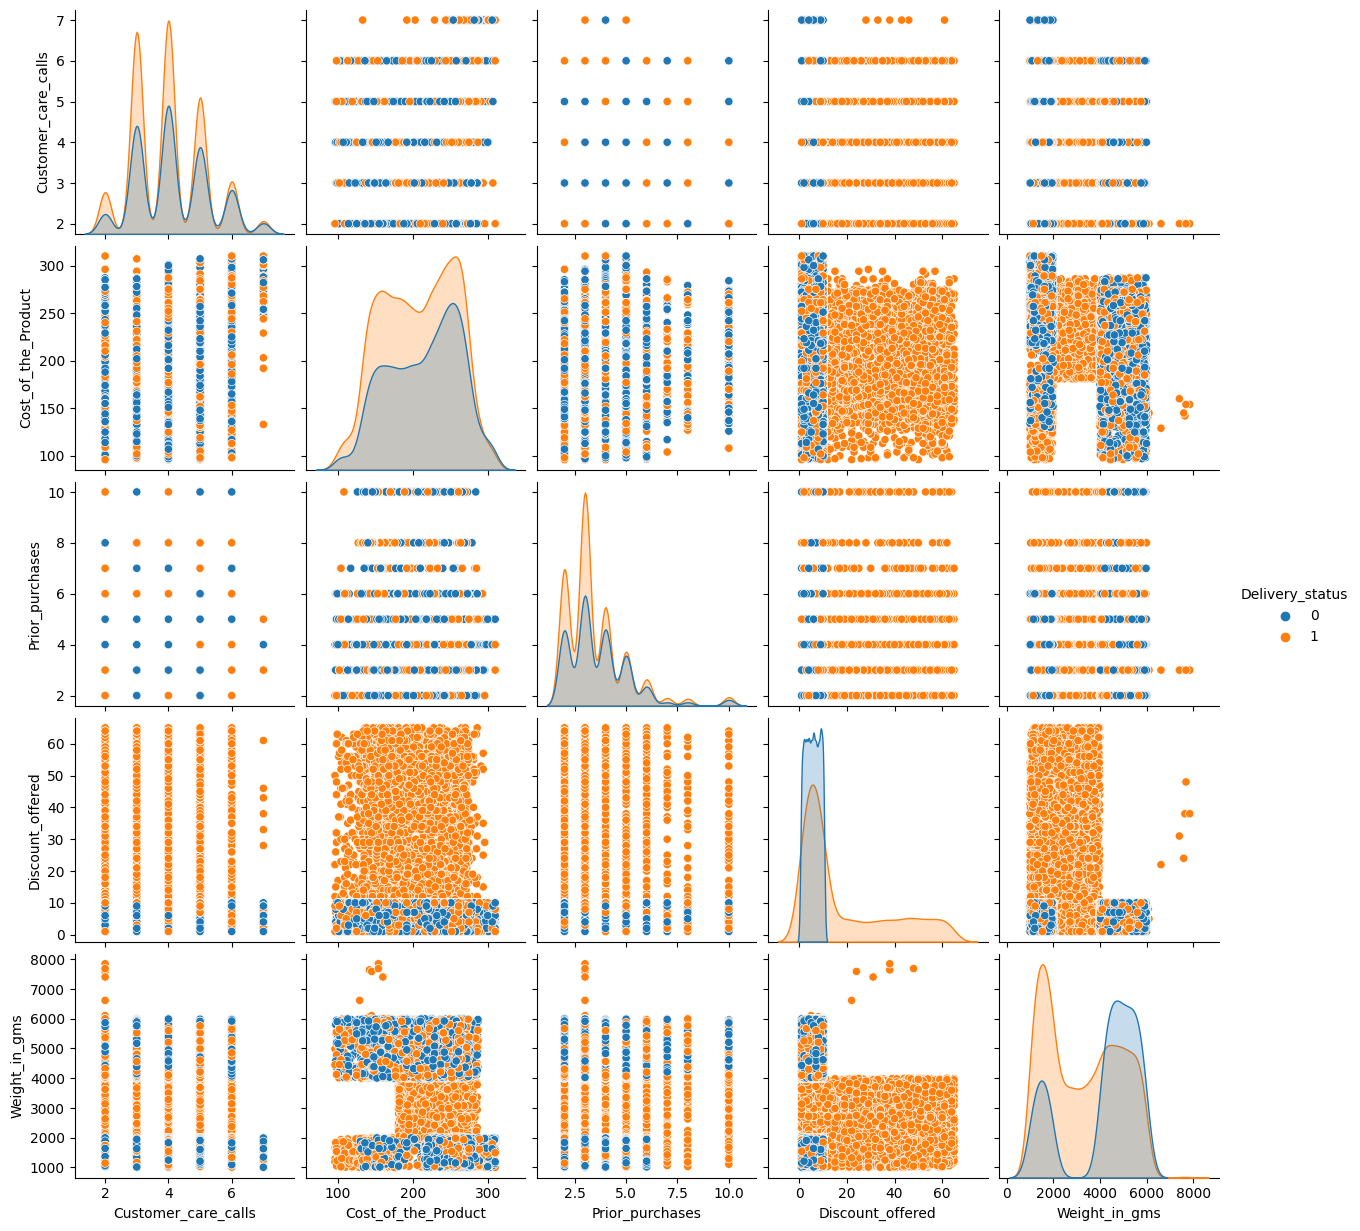

In [19]:
# Pair plot
sns.pairplot(data = df, diag_kind = 'kde', hue = 'Delivery_status', hue_order = ['0', '1'])

The late product shipment tend to cluster at:
- Higher amount of discount offered
- Several medium weight range and lower weight range

We can further explore to the boxplot of numerical features vs. target

#### Box Plot

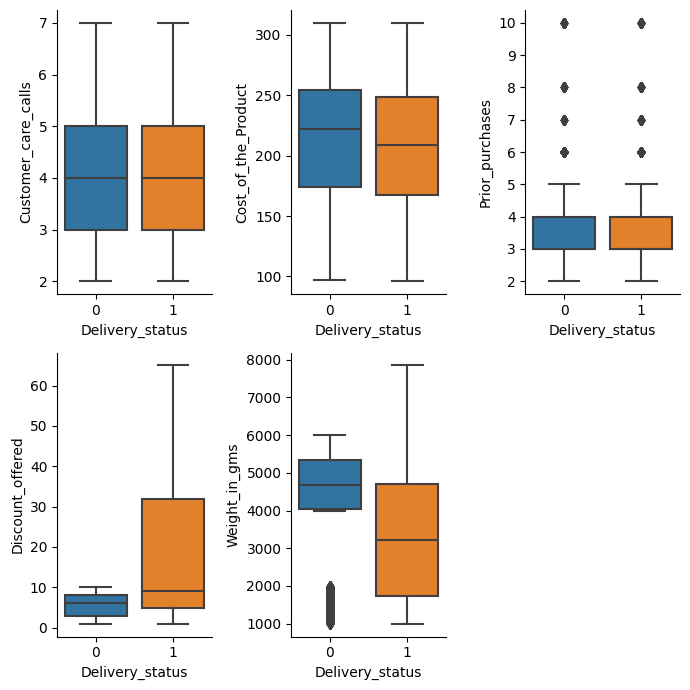

In [20]:
# Box plot
plt.figure(figsize = (7, 7))

for i in range(0, len(nums)):
    plt.subplot(2, 3, i + 1)
    ax = sns.boxplot(x = df['Delivery_status'].sort_values(), y = df[nums[i]])
    sns.despine(right = True)

plt.tight_layout()
plt.show()

Now, we can further confirm that:
- Late deliveries always happened at a higher amount of discount offered (> 10% of discount)
- Late deliveries always occured at the weight range of 1000 - 4000 gr and more than 6000 gr
- Other numerical variables doesn't show much difference between on time and late deliveries

**Indication of good features list**
1. `Discount_offered`
2. `Weight_in_gms`

Now, let's move on to find the relationships between categorical features and our target (`Delivery_status`).

### Categorical (Warehouse Block) vs. Target
Because we're comparing different attributes of on-time vs. late deliveries. We will base our comparison with frequency and proportion.

<Figure size 1000x500 with 0 Axes>

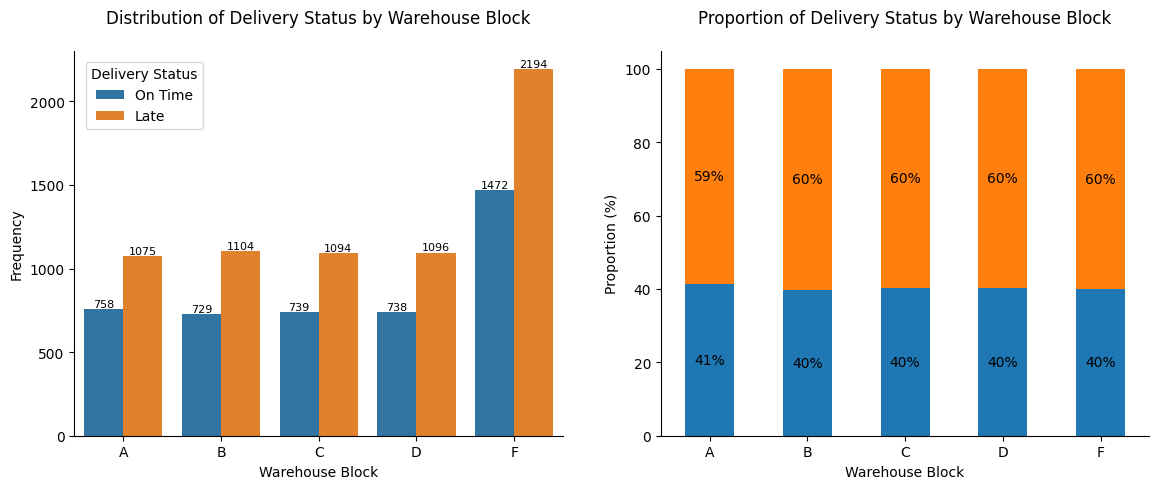

In [21]:
plt.figure(figsize = (10, 5))

# Frequency base
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(right = 1.2)
sns.despine(right = True)

sns.countplot(ax = axes[0], x = df['Warehouse_block'], hue = df['Delivery_status'].sort_values(), order = sorted(df['Warehouse_block'].unique().tolist()))

axes[0].bar_label(axes[0].containers[0], label_type = 'edge', fontweight = 'normal', size = 8)
axes[0].bar_label(axes[0].containers[1], label_type = 'edge', fontweight = 'normal', size = 8)

axes[0].set(ylabel = 'Frequency', xlabel = 'Warehouse Block')
axes[0].set_title('Distribution of Delivery Status by Warehouse Block', y = 1.05)
axes[0].legend(['On Time', 'Late'], loc = 0, ncol = 1, title = 'Delivery Status', borderaxespad = 0.8)

# Proportion base
wb_p = df.groupby(['Warehouse_block', 'Delivery_status'])['Delivery_status'].count().reset_index(name = 'Freq')
wb_p['Prop'] = round(wb_p['Freq'] / wb_p.groupby('Warehouse_block')['Freq'].transform(sum) * 100, 2)
wb_p.pivot_table(index='Warehouse_block', columns='Delivery_status', values='Prop').plot(kind='bar', stacked=True, ax=axes[1])

axes[1].bar_label(axes[1].containers[0], label_type='center', fontweight='light', fmt='%.0f%%')
axes[1].bar_label(axes[1].containers[1], label_type='center', fontweight='light', fmt='%.0f%%')

axes[1].set_title('Proportion of Delivery Status by Warehouse Block', y = 1.05)
axes[1].set(ylabel = 'Proportion (%)', xlabel = 'Warehouse Block')
axes[1].set_xticks(ticks = axes[1].get_xticks(), labels = axes[1].get_xticklabels(), rotation = 0)

axes[1].get_legend().set_visible(False)

plt.show()

Observation results:

- All deliveries mostly are late across all warehouse blocks
- When we compare the similar late and on-time delivery proportions for each warehouse block, we can see that the warehouse block itself does not significantly influence whether a shipment will be late or on time.

### Categorical (Mode of Shipment) vs. Target

<Figure size 1000x500 with 0 Axes>

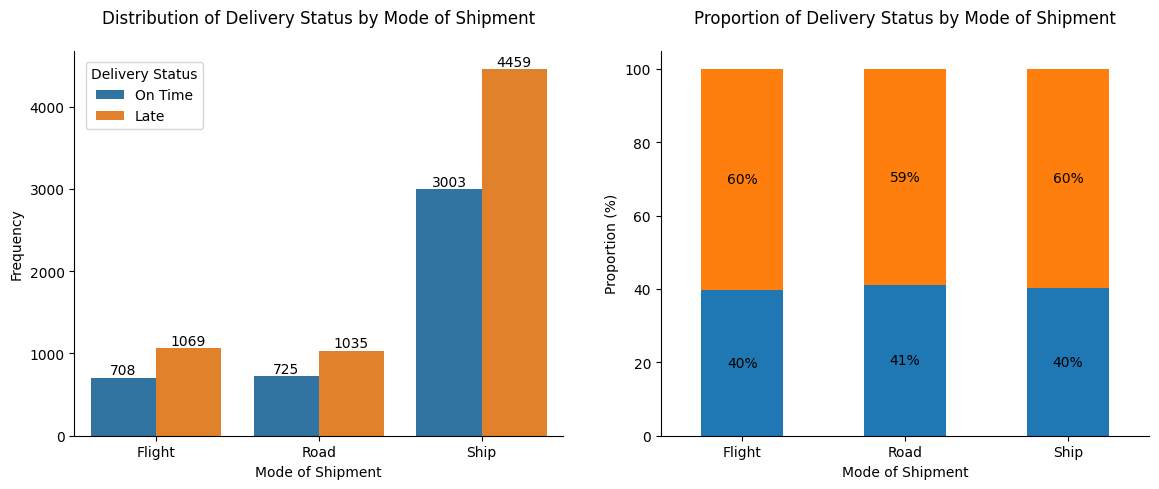

In [22]:
plt.figure(figsize = (10, 5))

# Frequency base
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(right = 1.2)
sns.despine(right = True)

sns.countplot(ax = axes[0], x = df['Mode_of_Shipment'], hue = df['Delivery_status'].sort_values(), order = ['Flight', 'Road', 'Ship'])

axes[0].bar_label(axes[0].containers[0], label_type = 'edge', fontweight = 'normal')
axes[0].bar_label(axes[0].containers[1], label_type = 'edge', fontweight = 'normal')

axes[0].set(ylabel = 'Frequency', xlabel = 'Mode of Shipment')
axes[0].set_title('Distribution of Delivery Status by Mode of Shipment', y = 1.05)
axes[0].legend(['On Time', 'Late'], loc = 0, ncol = 1, title = 'Delivery Status', borderaxespad = 0.8)

# Proportion base
mos_p = df.groupby(['Mode_of_Shipment', 'Delivery_status'])['Delivery_status'].count().reset_index(name = 'Freq')
mos_p['Prop'] = round(mos_p['Freq'] / mos_p.groupby('Mode_of_Shipment')['Freq'].transform(sum) * 100, 2)
mos_p.pivot_table(index='Mode_of_Shipment', columns='Delivery_status', values='Prop').plot(kind='bar', stacked=True, ax=axes[1])

axes[1].bar_label(axes[1].containers[0], label_type='center', fontweight='light', fmt='%.0f%%')
axes[1].bar_label(axes[1].containers[1], label_type='center', fontweight='light', fmt='%.0f%%')

axes[1].set_title('Proportion of Delivery Status by Mode of Shipment', y = 1.05)
axes[1].set(ylabel = 'Proportion (%)', xlabel = 'Mode of Shipment')
axes[1].set_xticks(ticks = axes[1].get_xticks(), labels = axes[1].get_xticklabels(), rotation = 0)

axes[1].get_legend().set_visible(False)

plt.show()

Observation results:
- All deliveries mostly are late across all mode of shipment.
- We can see that mode of shipment does not significantly impact delivery lateness, as each mode of shipment shows a similar rate of on time and late deliveries.

### Categorical (Customer Rating) vs. Target

<Figure size 1000x500 with 0 Axes>

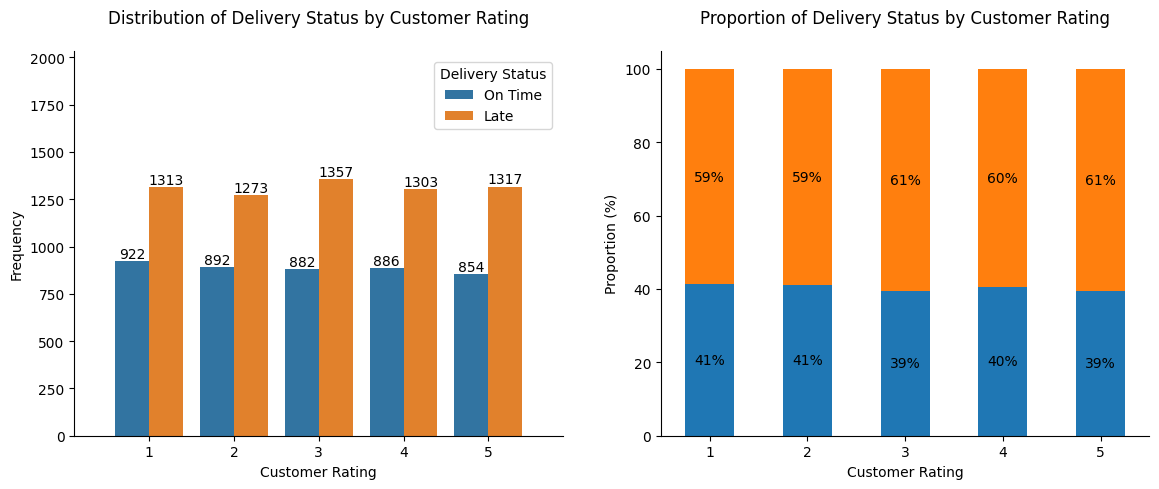

In [23]:
plt.figure(figsize = (10, 5))

# Frequency base
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(right = 1.2)
sns.despine(right = True)

sns.countplot(ax = axes[0], x = df['Customer_rating'], hue = df['Delivery_status'].sort_values(),
              order = sorted(df['Customer_rating'].unique().tolist()))

axes[0].bar_label(axes[0].containers[0], label_type = 'edge', fontweight = 'normal')
axes[0].bar_label(axes[0].containers[1], label_type = 'edge', fontweight = 'normal')

axes[0].set(ylabel = 'Frequency', xlabel = 'Customer Rating')
axes[0].set_title('Distribution of Delivery Status by Customer Rating', y = 1.05)
axes[0].legend(['On Time', 'Late'], loc = 0, ncol = 1, title = 'Delivery Status', borderaxespad = 0.8)
axes[0].margins(0.1, 0.5)

# Proportion base
cr_p = df.groupby(['Customer_rating', 'Delivery_status'])['Delivery_status'].count().reset_index(name = 'Freq')
cr_p['Prop'] = round(cr_p['Freq'] / cr_p.groupby('Customer_rating')['Freq'].transform(sum) * 100, 2)
cr_p.pivot_table(index='Customer_rating', columns='Delivery_status', values='Prop').plot(kind='bar', stacked=True, ax=axes[1])

axes[1].bar_label(axes[1].containers[0], label_type='center', fontweight='light', fmt='%.0f%%')
axes[1].bar_label(axes[1].containers[1], label_type='center', fontweight='light', fmt='%.0f%%')

axes[1].set_title('Proportion of Delivery Status by Customer Rating', y = 1.05)
axes[1].set(ylabel = 'Proportion (%)', xlabel = 'Customer Rating')
axes[1].set_xticks(ticks = axes[1].get_xticks(), labels = axes[1].get_xticklabels(), rotation = 0)

axes[1].get_legend().set_visible(False)

plt.show()

Observation results:
- All deliveries mostly are late across all customer ratings.
- Based on the proportions, we can see that there is not much differences between customer rating of 1 to 5. This means that customer rating doesn't influence the status of a delivery (whether it will late or not).

### Categorical (Product Importance) vs. Target

<Figure size 1000x500 with 0 Axes>

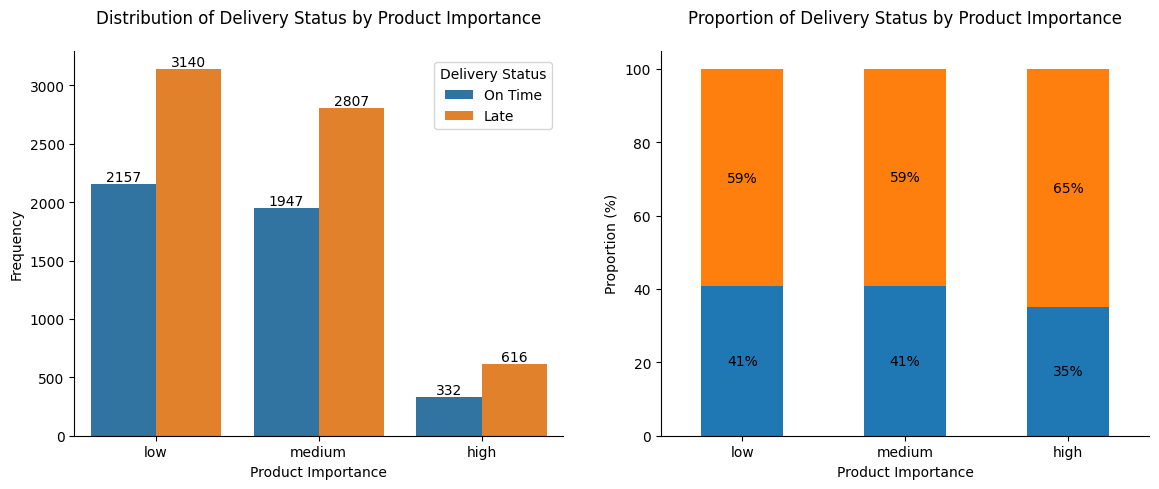

In [24]:
plt.figure(figsize = (10, 5))

# Frequency base
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(right = 1.2)
sns.despine(right = True)

sns.countplot(ax = axes[0], x = df['Product_importance'], hue = df['Delivery_status'].sort_values(), order = ['low', 'medium', 'high'])

axes[0].bar_label(axes[0].containers[0], label_type = 'edge', fontweight = 'normal')
axes[0].bar_label(axes[0].containers[1], label_type = 'edge', fontweight = 'normal')

axes[0].set(ylabel = 'Frequency', xlabel = 'Product Importance')
axes[0].set_title('Distribution of Delivery Status by Product Importance', y = 1.05)
axes[0].legend(['On Time', 'Late'], loc = 0, ncol = 1, title = 'Delivery Status', borderaxespad = 0.8)

# Proportion base
pi_p = df.groupby(['Product_importance', 'Delivery_status'])['Delivery_status'].count().reset_index(name = 'Freq')
pi_p['Prop'] = round(pi_p['Freq'] / pi_p.groupby('Product_importance')['Freq'].transform(sum) * 100, 2)
pi_p['Product_importance'] = pd.Categorical(pi_p['Product_importance'], ['low', 'medium', 'high'])
pi_p.sort_values('Product_importance', inplace = True)
pi_p.pivot_table(index='Product_importance', columns='Delivery_status', values='Prop').plot(kind='bar', stacked=True, ax=axes[1])

axes[1].bar_label(axes[1].containers[0], label_type='center', fontweight='light', fmt='%.0f%%')
axes[1].bar_label(axes[1].containers[1], label_type='center', fontweight='light', fmt='%.0f%%')

axes[1].set_title('Proportion of Delivery Status by Product Importance', y = 1.05)
axes[1].set(ylabel = 'Proportion (%)', xlabel = 'Product Importance')
axes[1].set_xticks(ticks = axes[1].get_xticks(), labels = axes[1].get_xticklabels(), rotation = 0)

axes[1].get_legend().set_visible(False)

plt.show()

Observation results:
- All deliveries mostly are late across all product importance.
- Looking at the proportions, it's visible that products categorized as high importance are more likely to experience late deliveries compared to those categorized as low and medium importance. This indicates that product importance is one of the factors influencing whether a delivery will be late or not.

### Categorical (Gender) vs. Target

<Figure size 1000x500 with 0 Axes>

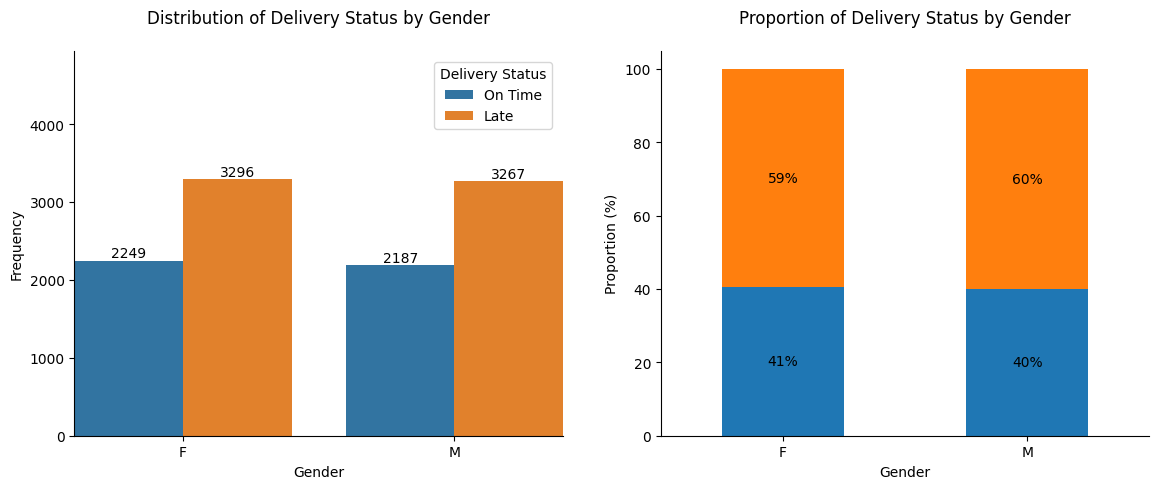

In [25]:
plt.figure(figsize = (10, 5))

# Frequency base
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(right = 1.2)
sns.despine(right = True)

sns.countplot(ax = axes[0], x = df['Gender'], hue = df['Delivery_status'].sort_values())

axes[0].bar_label(axes[0].containers[0], label_type = 'edge', fontweight = 'normal')
axes[0].bar_label(axes[0].containers[1], label_type = 'edge', fontweight = 'normal')

axes[0].set(ylabel = 'Frequency', xlabel = 'Gender')
axes[0].set_title('Distribution of Delivery Status by Gender', y = 1.05)
axes[0].legend(['On Time', 'Late'], loc = 0, ncol = 1, title = 'Delivery Status', borderaxespad = 0.8)
axes[0].margins(0, 0.5)

# Proportion base
g_p = df.groupby(['Gender', 'Delivery_status'])['Delivery_status'].count().reset_index(name = 'Freq')
g_p['Prop'] = round(g_p['Freq'] / g_p.groupby('Gender')['Freq'].transform(sum) * 100, 2)
g_p.pivot_table(index='Gender', columns='Delivery_status', values='Prop').plot(kind='bar', stacked=True, ax=axes[1])

axes[1].bar_label(axes[1].containers[0], label_type='center', fontweight='light', fmt='%.0f%%')
axes[1].bar_label(axes[1].containers[1], label_type='center', fontweight='light', fmt='%.0f%%')

axes[1].set_title('Proportion of Delivery Status by Gender', y = 1.05)
axes[1].set(ylabel = 'Proportion (%)', xlabel = 'Gender')
axes[1].set_xticks(ticks = axes[1].get_xticks(), labels = axes[1].get_xticklabels(), rotation = 0)

axes[1].get_legend().set_visible(False)

plt.show()

Observation results:
- All deliveries mostly are late across all genders
- We can see that there's no significant effect of gender to late deliveries because the proportion of late and on time deliveries across all gender is highly similar

**Indication of good features list**

1. `Discount_offered`
2. `Weight_in_gms`
3. `Product_importance`

**What is the correlation between features, are there any interesting patterns? What needs to be done with that feature?**

- Based on the correlation heatmap, we could see that several features have weak to moderate relationship with other features. Further checked with VIF, we'll drop some features later on to eliminate the multicollinearity problem.

## Business Insights & Recommendations (EDA Based)
After the exploration phase above, we find several factors that are associated with late deliveries in this dataset.

### Business Insight

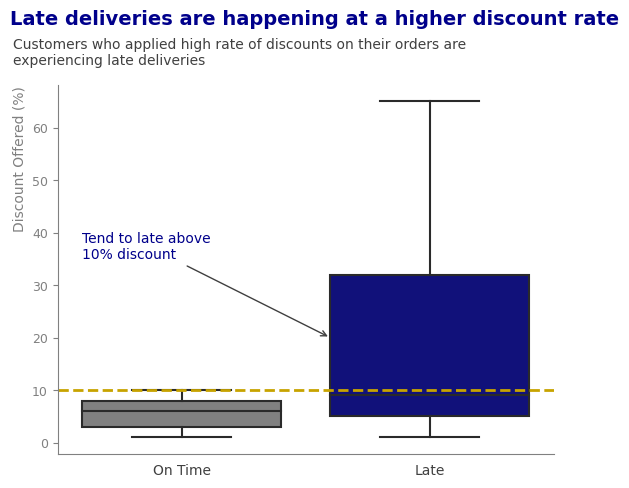

In [26]:
ax = sns.boxplot(x = df['Delivery_status'].sort_values(), y = df['Discount_offered'], palette = ['gray', 'darkblue'])
sns.despine(right = True)

ax.axhline(df[df['Delivery_status'] == '0']['Discount_offered'].max(), color = '#C7A300', ls = '--', lw = 2)

plt.title('Late deliveries are happening at a higher discount rate', weight = 'bold', c = 'darkblue', x = 0.518, y = 1.14, size = 14)
ax.annotate(xytext = (-0.4, 35), xy = (0.6, 20), text = 'Tend to late above \n10% discount', color = 'darkblue', arrowprops = dict(arrowstyle = '->', color = '#404040'))
plt.text(s = 'Customers who applied high rate of discounts on their orders are \nexperiencing late deliveries', c = '#404040', x = -0.68, y = 72)

ax.set_xticklabels(['On Time', 'Late'], color = '#404040')
plt.setp(ax.get_yticklabels(), color = "gray", size = 9)
ax.tick_params(color = "gray", bottom = False)

ax.set_xlabel('')
ax.set_ylabel('Discount Offered (%)', color = "gray", y = 0.8)

for spine in ax.spines.values():
    spine.set_edgecolor("gray")

plt.show()

Customers who ordered and applied a discount of more than 10% are experiencing late deliveries. This means that a higher amount of discount is associated with late deliveries. The higher the discount offered, the higher the probability of the delivery status will be late. Thus, recommendations regarding the amount of discount offered need to be given.

Here are several assumptions regarding the lateness in higher discounted shipments:
1. **Resource Allocation**: The company may prioritize orders with lower discounts, as they might generate higher profit margins. This could result in fewer resources and attention given to orders with higher discounts, leading to delays in processing and shipment.
2. **Limited Supply**: Orders with higher discounts may be for products that are limited in supply. This could lead to possible inventory shortages and cause delays.

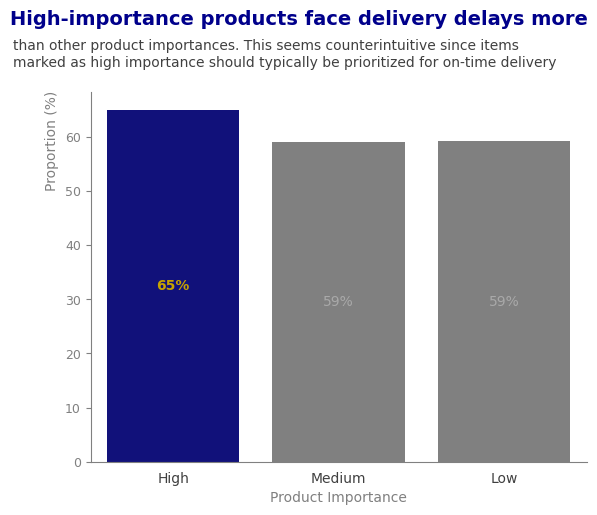

In [27]:
# Proportion base

late_pi_p = pi_p[pi_p['Delivery_status'] == '1'][['Product_importance', 'Prop']].rename(columns = {'Prop' : 'Late_prop'})

ax = sns.barplot(x = late_pi_p['Product_importance'], y = late_pi_p['Late_prop'],
                 palette = ['darkblue', 'gray', 'gray'], order = ['high', 'medium', 'low'])
sns.despine(right = True)

barlab = plt.bar_label(ax.containers[0], label_type = 'center', fontweight = 'normal', fmt = '%.0f%%', color = 'darkgray')
barlab[0].set(color = '#C7A300', weight = 'bold')

plt.setp(ax.get_yticklabels(), color = "gray", size = 9)
ax.tick_params(color = "gray", bottom = False)

ax.set_xticklabels(['High', 'Medium', 'Low'], color = '#404040')
ax.set_xlabel('Product Importance', color = "gray")
ax.set_ylabel('Proportion (%)', color = "gray", y = 0.87)

plt.title('High-importance products face delivery delays more', weight = 'bold', c = 'darkblue', x = 0.42, y = 1.16, size = 14)
plt.text(s = 'than other product importances. This seems counterintuitive since items \nmarked as high importance should typically be prioritized for on-time delivery',
         c = '#404040', x = -0.97, y = 73)

for spine in ax.spines.values():
    spine.set_edgecolor("gray")

plt.show()

High importance products category tend to experience more late deliveries than other product importance levels. It is important to identify and overcome the causes of this lateness in detail (need more data about the detail about the characteristics of "High" importance goods) to improve the delivery performance of high importance category products

Here are several assumptions regarding the lateness in high product importance:
1. **Complex Handling**: High importance orders may require more complex handling, like specialized packaging or stricter quality checks, which can lead to delays in the shipment process.

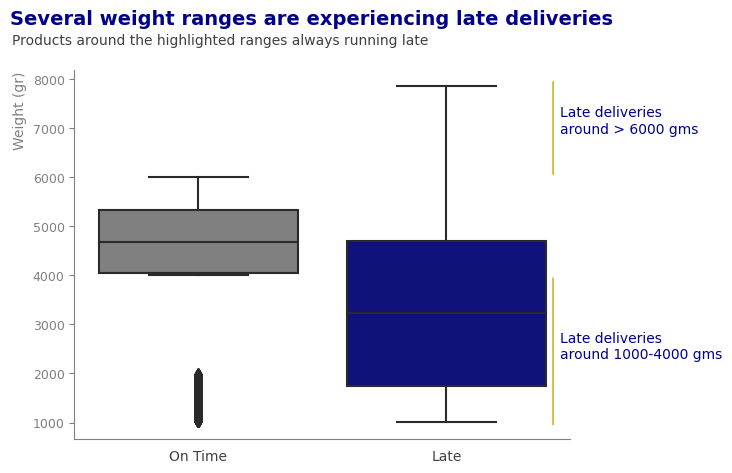

In [28]:
ax = sns.boxplot(x = df['Delivery_status'].sort_values(), y = df['Weight_in_gms'], palette = ['gray', 'darkblue'])
sns.despine(right = True)

plt.title('Several weight ranges are experiencing late deliveries', weight = 'bold', c = 'darkblue', x = 0.478, y = 1.1, size = 14)
plt.text(s = 'Products around the highlighted ranges always running late', c = '#404040', x = -0.75, y = 8700)

ax.annotate(xytext = (1.43, 4000), xy = (1.43, 900), text = '', arrowprops = dict(arrowstyle = '-', color = '#C7A300'))
plt.text(s = 'Late deliveries \naround 1000-4000 gms', x = 1.46, y = 2300, color = 'darkblue')
ax.annotate(xytext = (1.43, 8000), xy = (1.43, 6000), text = '', arrowprops = dict(arrowstyle = '-', color = '#C7A300'))
plt.text(s = 'Late deliveries \naround > 6000 gms', x = 1.46, y = 6900, color = 'darkblue')

ax.set_xticklabels(['On Time', 'Late'], color = '#404040')
plt.setp(ax.get_yticklabels(), color = "gray", size = 9)
ax.tick_params(color = "gray", bottom = False)

ax.set_xlabel('')
ax.set_ylabel('Weight (gr)', color = "gray", y = 0.89)

for spine in ax.spines.values():
    spine.set_edgecolor("gray")

plt.show()

Products/goods weighing around 1000 - 4000 gr and more than 6000 gr experience more late deliveries than other weight ranges. Further analysis needs to be carried out to identify specific influencing factors to improve heavy product delivery performance.

Nevertheless, the lateness seems to be more concentrated around lighter products' weight that we can see from the center of the distribution.

*Side note: The late weight range starts from 1000 gr because on-time deliveries at around 1000-2000gr is considered an outlier, meaning that there's not much on-time deliveries at that weight range*

Here are several assumptions regarding the lateness in lighter products' weight:
1. **Resource Imbalance**: Companies may prioritize shipments with weights over 4000 gr because they can generate more revenue. This can lead to resource imbalance, where products under 4000 gr are not adequately resourced.

### Business Recommendations

This section provides insights and recommendations based on the current dataset. For more accurate and specific follow-up actions, additional data may be required, depending on the type of factors that cause late deliveries.

1. **Discount factor:** There is a tendency that the larger the discount given, the more likely the order is to be late. This could be due to several factors, such as high demand for products with large discounts or possible impacts on the delivery process. Interim recommendations that can be made:

  - **Implementing a Discount Threshold Policy (to be simulated later):** Simulate the impact of setting a maximum discount threshold (10%) for orders. Test whether limiting discounts to this threshold can reduce late deliveries. This policy can help balance between attracting customers through discounts and ensuring on-time delivery.

  - **Shipping System:** Consider optimizing the shipping system/routes for products with large discounts, so that items always arrive on time for products with large discounts.

  - **Continuously Monitor:** Monitor late deliveries of products with large discounts specifically and strive to minimize them.

  *Note: Limiting discounts may seem counterintuitive. However, here are some of the things we can gain from this policy:*

    - Reduce Late Deliveries: As has been observed, higher discounts are associated with late deliveries. Limiting discounts can help ensure that the company meets its delivery commitments and maintains a better on-time delivery rate, which is essential for customer satisfaction.

    - Improve Profit Margins: By limiting discounts to 10%, the company can maintain better profit margins on its products. Higher discounts can significantly reduce profits.

2. **Product Importance Influence:** Products categorized as "High" are more likely to be late. This suggests that the "High" category may require special attention to meet delivery schedules. We need additional data on the characteristics of "High" importance products to analyze in more detail. However, there are some interim suggestions that can be made:

  - **Dedicated Team Assignment:** Form a dedicated team for the delivery of "high" importance products. This team will have the resources and expertise necessary to ensure on-time delivery for "high" importance items.

  - **Premium Shipping Services:** Use shipping companies with a good reputation and track record, especially for "High" importance products. This ensures on-time and fast delivery, even if there is a potential for late delivery.

3. **Weight Factor:** It is seen that some weight ranges (mainly in the 1000-4000 gr range) of products tend to be late. This could be due to the complexity of the process of shipping several items with the mentioned weight ranges or the need for different shipping methods. We need more data on the characteristics of products that have weights in those ranges. Here are some interim recommendations that can be implemented:

  - **Further Analysis:** Identify in more detail why products with the aforementioned weights are late. Are there any problems in the delivery process that need to be fixed? Consider adjusting the shipping or logistics process specifically for these products so that they can be shipped more efficiently and on time. Ensure that customers are given realistic delivery estimates for products with certain weights.

  - **Product Packaging:** One of the reasons why some items with certain weights are prone to being late can be caused by the packaging of the item itself:

    - **Packaging Strength:** Evaluate whether the packaging used for products in that range is strong enough to withstand the weight and handling during shipping. Weak packaging can cause product damage and order delays.

    - **Seal Quality:** Make sure the sealing of these packages is secure. Insufficient sealing can cause items to shift during transportation, potentially leading to delays and damage.

    - **Weight Label Accuracy:** Make sure the accuracy of the weight label on the package is correct. The wrong weight labeling process can result in the selection of an inappropriate transportation method, leading to late delivery (e.g., items with heavy weight labels are shipped using small modes of transportation, and vice versa).

Overall, it is important for businesses to continuously monitor and improve logistics and delivery processes to ensure timely and reliable service to customers. These recommendations should be a starting point for addressing potential problems and optimizing on-time delivery rates.

# Cleaning and Preprocessing
Before going into the modelling phase, we need to clean and preprocess our data to make the learning process more efficient and appropriate.

## Data Cleaning

### Missing Values Inspection

In [29]:
df.isna().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Delivery_status        0
dtype: int64

There is no empty data so we don't need to handle them



### Duplicates Inspection

In [30]:
df.duplicated().sum()

0

There is no duplicated data so we don't need to handle them

### Outliers Inspection
We'll base our outlier detection using the most common approach: Boxplot's IQR

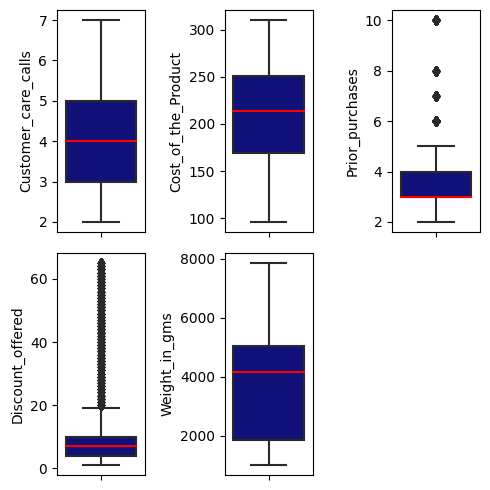

In [31]:
# Box Plot
plt.figure(figsize = (5, 5))

for i in range(0, len(nums)):
  plt.subplot(2, 3, i+1)
  sns.boxplot(y = df[nums[i]], color='darkblue', medianprops= dict(color='red'))

plt.tight_layout()
plt.show()

We have several collective outliers in the `Discount_offered` feature but the outlier values are still appropriate (`Discount_offered` ranges between 0% to 100%). Hence, we'll not drop any of them because despite outliers, they are still valid observations.

Regarding the `Prior_purchases`, we see several outliers but all of them still appropriate (6, 7, 8, or 10 prior purchases is still a valid number). Therefore, we'll not drop any of them because despite outliers, they're still valid observations.

### Class Imbalance Inspection

In [32]:
# Class imbalance check in percentage (%)
round(df['Delivery_status'].value_counts(normalize = True)*100, 2)

Delivery_status
1    59.67
0    40.33
Name: proportion, dtype: float64

The dataset is slightly imbalanced but no further action is needed.

### Feature with Multicolinearity Removal
As we mentioned before in the EDA, there are several features with multicollinearity but we will retain the feature with the most correlation with our target `Delivery_status`

In [33]:
# Independent variables set
X = df[nums]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

vif_data.sort_values('VIF', ascending = False)

,feature,VIF
1,Cost_of_the_Product,16.729226
0,Customer_care_calls,13.312730
2,Prior_purchases,6.238112
4,Weight_in_gms,4.482598
3,Discount_offered,1.605862


As a reminder, features that could cause multicollinearity are those with VIF > 10, namely `Cost_of_the_Product` and `Customer_care_calls`.

<Axes: >

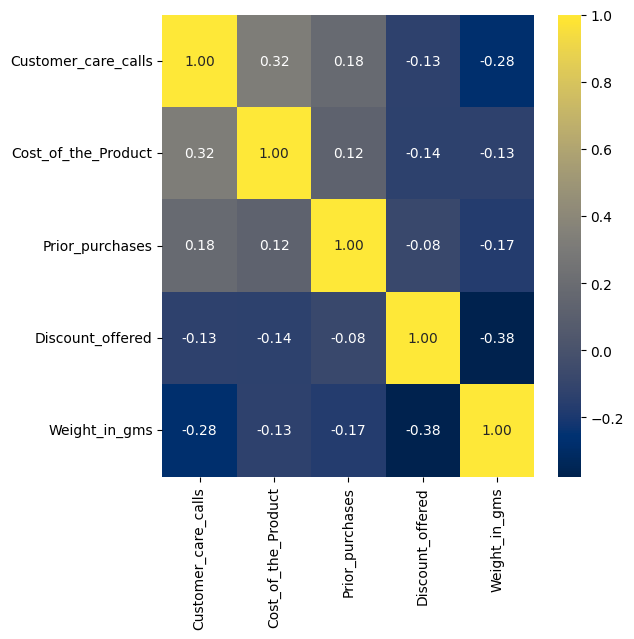

In [34]:
# Correlation Heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(df.corr(numeric_only = True), cmap='cividis', annot=True, fmt='.2f')

Despite the high VIF value of `Cost_of_the_Product`, it has better correlation with the target. Hence, we'll remove `Customer_care_calls` instead with lower correlation with the target.

In [35]:
df = df.drop(columns = 'Customer_care_calls')

Let's check the VIF again



In [36]:
# Independent variables set
nums.remove('Customer_care_calls')
X = df[nums]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

vif_data.sort_values('VIF', ascending = False)

,feature,VIF
0,Cost_of_the_Product,9.241904
1,Prior_purchases,5.725384
3,Weight_in_gms,4.476167
2,Discount_offered,1.601669


Now there's no more feature that has VIF > 10 and cause further multicollinearity.

## Feature Creation / Extraction

### Product Cost Class
This is a new feature that groups several ranges of values in the `Cost_of_the_Product` feature. We will base the grouping by its quantiles.

In [37]:
np.quantile(df['Cost_of_the_Product'], np.linspace(0, 1, 7))

array([ 96., 156., 184., 214., 240., 261., 310.])

From the quantile result above, we'll divide the grouping range by:

- Low = Orders with product that costs < \$185
- Medium = Orders with product that costs between \$185 - \$241
- High = Orders with product that costs > \$241

In [38]:
# Product cost class creation
def cost_classifier(Cost_of_the_Product):
    if Cost_of_the_Product < 185:
        return 'low'
    elif Cost_of_the_Product < 241:
        return 'medium'
    else:
        return 'high'

df['Cost_class'] = df['Cost_of_the_Product'].apply(cost_classifier)

Let's see if there are any differences in the delivery status rate between the cost classes.

<Figure size 1000x500 with 0 Axes>

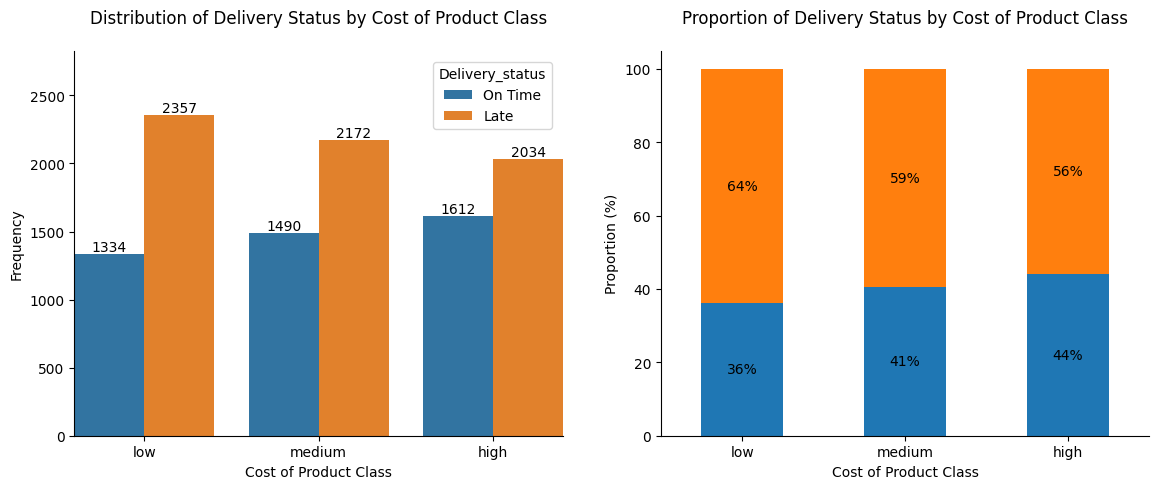

In [39]:
plt.figure(figsize = (10, 5))

# Frequency base
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(right = 1.2)
sns.despine(right = True)

sns.countplot(ax = axes[0], x = df['Cost_class'], hue = df['Delivery_status'].sort_values(), order = ['low', 'medium', 'high'])

axes[0].bar_label(axes[0].containers[0], label_type = 'edge', fontweight = 'normal')
axes[0].bar_label(axes[0].containers[1], label_type = 'edge', fontweight = 'normal')

axes[0].set(ylabel = 'Frequency', xlabel = 'Cost of Product Class')
axes[0].set_title('Distribution of Delivery Status by Cost of Product Class', y = 1.05)
axes[0].legend(['On Time', 'Late'], loc = 0, ncol = 1, title = 'Delivery_status', borderaxespad = 0.8)
axes[0].margins(0, 0.2)

# Proportion base
pc = df.groupby(['Cost_class', 'Delivery_status'])['Delivery_status'].count().reset_index(name = 'Freq')
pc['Prop'] = round(pc['Freq'] / pc.groupby('Cost_class')['Freq'].transform(sum) * 100, 2)
pc['Cost_class'] = pd.Categorical(pc['Cost_class'], ['low', 'medium', 'high'])
pc.sort_values('Cost_class', inplace = True)
pc.pivot_table(index='Cost_class', columns='Delivery_status', values='Prop').plot(kind='bar', stacked=True, ax=axes[1])

axes[1].bar_label(axes[1].containers[0], label_type='center', fontweight='light', fmt='%.0f%%')
axes[1].bar_label(axes[1].containers[1], label_type='center', fontweight='light', fmt='%.0f%%')

axes[1].set_title('Proportion of Delivery Status by Cost of Product Class', y = 1.05)
axes[1].set(ylabel = 'Proportion (%)', xlabel = 'Cost of Product Class')
axes[1].set_xticks(ticks = axes[1].get_xticks(), labels = axes[1].get_xticklabels(), rotation = 0)

axes[1].get_legend().set_visible(False)

plt.show()


This feature could be a good predictor to `Delivery_status` because as we can see above, the low, medium, and high product cost class delivery rate varies, where most deliveries are late in low cost class, followed by medium, and lastly high cost class.

### Prior Purchases Class
This feature is the transformed version of `Prior_purchases` where the value will be grouped to low, medium, and high. For the grouping base range, we'll check the unique values that it has first.

In [40]:
df['Prior_purchases'].value_counts().sort_index()

Prior_purchases
2     2599
3     3955
4     2155
5     1287
6      561
7      136
8      128
10     178
Name: count, dtype: int64

We can formulate the grouping as:

- low = Prior purchases < 4
- medium = Prior purchases from 4 to 6
- high = Prior purchases more than 6

In [41]:
# Prior purchase class creation
def prior_purchase_classifier(Prior_purchases):
    if Prior_purchases < 4:
        return 'low'
    elif Prior_purchases < 7:
        return 'medium'
    else:
        return 'high'

df['Prior_purchase_class'] = df['Prior_purchases'].apply(prior_purchase_classifier)

Let's see if there are any differences in the delivery status rate between the prior purchases classes.

<Figure size 1000x500 with 0 Axes>

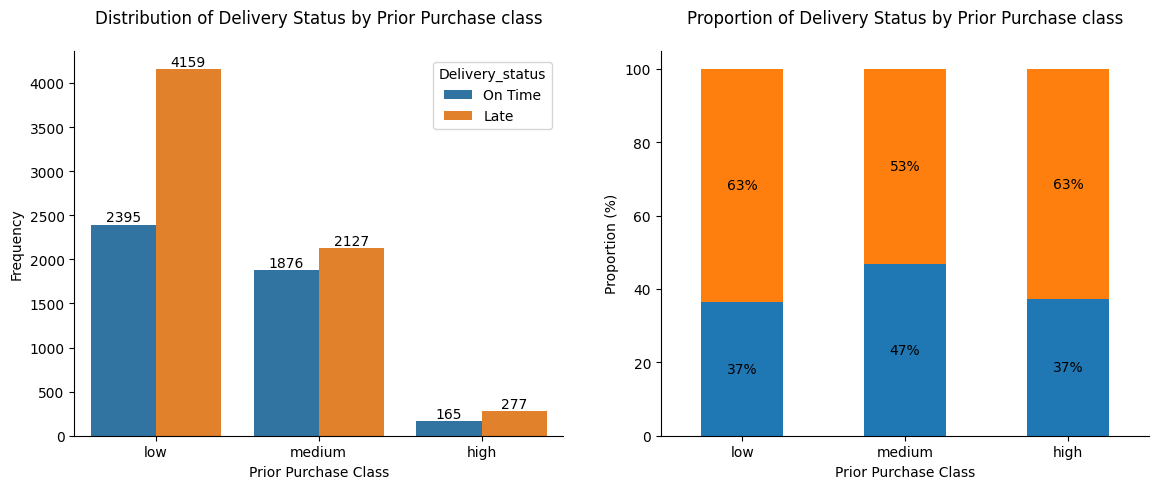

In [42]:
plt.figure(figsize = (10, 5))

# Frequency base
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(right = 1.2)
sns.despine(right = True)

sns.countplot(ax = axes[0], x = df['Prior_purchase_class'], hue = df['Delivery_status'].sort_values(), order = ['low', 'medium', 'high'])

axes[0].bar_label(axes[0].containers[0], label_type = 'edge', fontweight = 'normal')
axes[0].bar_label(axes[0].containers[1], label_type = 'edge', fontweight = 'normal')

axes[0].set(ylabel = 'Frequency', xlabel = 'Prior Purchase Class')
axes[0].set_title('Distribution of Delivery Status by Prior Purchase class', y = 1.05)
axes[0].legend(['On Time', 'Late'], loc = 0, ncol = 1, title = 'Delivery_status', borderaxespad = 0.8)

# Proportion base
ppc = df.groupby(['Prior_purchase_class', 'Delivery_status'])['Delivery_status'].count().reset_index(name = 'Freq')
ppc['Prop'] = round(ppc['Freq'] / ppc.groupby('Prior_purchase_class')['Freq'].transform(sum) * 100, 2)
ppc['Prior_purchase_class'] = pd.Categorical(ppc['Prior_purchase_class'], ['low', 'medium', 'high'])
ppc.sort_values('Prior_purchase_class', inplace = True)
ppc.pivot_table(index='Prior_purchase_class', columns='Delivery_status', values='Prop').plot(kind='bar', stacked=True, ax=axes[1])

axes[1].bar_label(axes[1].containers[0], label_type='center', fontweight='light', fmt='%.0f%%')
axes[1].bar_label(axes[1].containers[1], label_type='center', fontweight='light', fmt='%.0f%%')

axes[1].set_title('Proportion of Delivery Status by Prior Purchase class', y = 1.05)
axes[1].set(ylabel = 'Proportion (%)', xlabel = 'Prior Purchase Class')
axes[1].set_xticks(ticks = axes[1].get_xticks(), labels = axes[1].get_xticklabels(), rotation = 0)

axes[1].get_legend().set_visible(False)

plt.show()

Low and High prior purchases class is suffering more late deliveries than the medium prior purchase class. We can use this feature as a predictor in the model.

## Feature Encoding

### Ordinal Encoding

In [43]:
def custom_ordinal_encoding(data, column_name):
    def ordinal_classifier(x):
        if x == "low":
            return float(0)
        elif x == "medium":
            return float(1)
        elif x == "high":
            return float(2)

    data[column_name] = data[column_name].apply(ordinal_classifier)

custom_ordinal_encoding(df, "Product_importance")
custom_ordinal_encoding(df, "Cost_class")
custom_ordinal_encoding(df, "Prior_purchase_class")

We have implemented encoding in the category data used by creating a custom function called `custom_ordinal_encoding`. This function accepts column names, dataset, and categories as its input parameters, which allows us to efficiently and consistently perform ordinal encoding on each column that requires transformation, increasing clarity and reducing the risk of errors in the code, as well as maintaining consistency in the mapping of category values "low," "medium," and "high."

## Converting Target back to Integer
We need to convert the target back to integer type so it can be used by the model.

In [44]:
df['Delivery_status'] = df['Delivery_status'].astype('int64')

## Data Splitting
Here are the variables that we will use in the model:

1. Numeric
  - Discount_offered
  - Weight_in_gms
2. Categorical: Ordinal
  - Product_importances
  - Cost_class
  - Prior_Purchase_class

In [45]:
from sklearn.model_selection import train_test_split

X = df[['Discount_offered', 'Weight_in_gms', 'Product_importance', 'Cost_class', 'Prior_purchase_class']]
y = df[['Delivery_status']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 24)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7699, 5), (3300, 5), (7699, 1), (3300, 1))

## Feature Transformation (Normalizing the Skewed Distribution)
`Discount_offered` have a skewed distribution problem. We need to normalize the distribution before stepping into modelling. First, we'll see the minimum value that `Discount_offered` have so we would know what are the available methods for normalization

*Note: As this first section is only inspecting the initial distribution shape and skewness plus benchmarking all the available transformation methods, we'll use the main dataset. Further transformation will be made after benchmark on splitted data*

In [46]:
df['Discount_offered'].min()

1

We know that it doesn't have 0 or negative values, so we will benchmark the following normalization methods:
1. Square Root
2. Cube Root
3. Log
4. Reciprocal
5. Box Cox
6. Yeo-Johnson

Let's see the shape and skewness first

<Axes: xlabel='Discount_offered', ylabel='Count'>

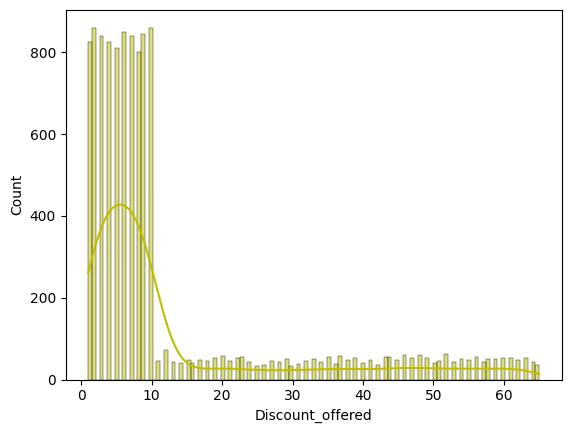

In [47]:
sns.histplot(x=df['Discount_offered'],kde = True, color='y')

In [48]:
old_skew = df[['Discount_offered']].skew().to_frame().reset_index()
old_skew.columns = ['feature','old_skew']
old_skew

,feature,old_skew
0,Discount_offered,1.798929


Now let's do the benchmark.

In [49]:
from sklearn.preprocessing import PowerTransformer


li = old_skew['feature'].values.tolist()
a = old_skew.copy()

# Common Methods
sqrt_list = []
cbrt_list = []
log_list = []
sq_list = []
cb_list = []

for i in li:
  sqrt_list.append(round(np.sqrt(X_train[i]).skew(), 2))
  cbrt_list.append(round(np.cbrt(X_train[i]).skew(), 2))
  log_list.append(round(np.log(X_train[i]).skew(), 2))
  sq_list.append(round(np.square(X_train[i]).skew(), 2))
  cb_list.append(round(np.power(X_train[i], 3).skew(), 2))

a['sqrt'] = sqrt_list
a['cbrt'] = cbrt_list
a['log'] = log_list
a['sq'] = sq_list
a['cb'] = cb_list

# PowerTransformer
bx_list = []
yj_list = []

for i in li:
  if 0 in df[i].values:
    bx_list.append(None)
  else:
    box_cox = PowerTransformer(method = 'box-cox')
    res = box_cox.fit_transform(X_train[i].values.reshape(len(X_train), 1)).tolist()
    res = [item for sublist in res for item in sublist]
    bx_list.append(pd.Series(res).skew().round(2))

a['box-cox'] = bx_list

for i in li:
    yj = PowerTransformer()
    res = yj.fit_transform(X_train[i].values.reshape(len(X_train), 1)).tolist()
    res = [item for sublist in res for item in sublist]
    yj_list.append(pd.Series(res).skew().round(2))

a['yeo-johnson'] = yj_list
a

,feature,old_skew,sqrt,cbrt,log,sq,cb,box-cox,yeo-johnson
0,Discount_offered,1.798929,1.22,0.94,0.22,2.41,2.92,0.01,0.05


Observation result:

- **Box-cox** normalization technique is the most effective in reducing skewness.

Now let's fit the transformer to the train data and apply to both train and test

In [50]:
# Transform process
disc_off_train = X_train[['Discount_offered']]
disc_off_test = X_test[['Discount_offered']]

pt = PowerTransformer(method = "box-cox").set_output(transform="pandas")
boxcox = pt.fit(disc_off_train)

disc_off_train = boxcox.transform(disc_off_train)
disc_off_test = boxcox.transform(disc_off_test)

X_train['Discount_offered'] = disc_off_train
X_test['Discount_offered'] = disc_off_test

In [51]:
# X_train Skewness after transform

X_train['Discount_offered'].skew()

0.012958338609009518

In [52]:
# X_test Skewness after transform

X_test['Discount_offered'].skew()

0.0009439049516881328

## Feature Scaling

We will use StandardScaler as the scaling method because many of the features' initial distribution is approximately normal

In [53]:
from sklearn.preprocessing import StandardScaler

# X_train scaling
scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# X_test scaling
X_test = scaler.transform(X_test)

# Modelling

## Initial Evaluation for Model Selection
Recall is the primary evaluation metric for this project because we want to minimize false negatives. False negatives are costly because they represent late deliveries that are predicted to be on time. This can make customers unhappy and less trusting of our company.

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate

In [55]:
# Cross validation function for initial evaluation
def cross_validation(models):
    model_name = []

    # Evaluation empty lists
    cv_accuracy_mean = []
    training_accuracy = []

    cv_precision_mean = []
    training_precision = []

    cv_recall_mean = []
    training_recall = []

    cv_f1_mean = []
    training_f1 = []

    cv_roc_auc_mean = []
    training_roc_auc = []

    for name, model in models:
        model_name.append(name)

        # Initializing evaluation lists
        scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

        # Cross validate
        cv_score = cross_validate(model, X_train, y_train, scoring = scoring, cv = 5, return_train_score = True)

        cv_accuracy_mean.append(cv_score['test_accuracy'].mean())
        training_accuracy.append(cv_score['train_accuracy'].mean())

        cv_precision_mean.append(cv_score['test_precision'].mean())
        training_precision.append(cv_score['train_precision'].mean())

        cv_recall_mean.append(cv_score['test_recall'].mean())
        training_recall.append(cv_score['train_recall'].mean())

        cv_f1_mean.append(cv_score['test_f1'].mean())
        training_f1.append(cv_score['train_f1'].mean())

        cv_roc_auc_mean.append(cv_score['test_roc_auc'].mean())
        training_roc_auc.append(cv_score['train_roc_auc'].mean())

    return pd.DataFrame({
        'Model': model_name,
        'Training Accuracy': training_accuracy,
        'Test Accuracy': cv_accuracy_mean,
        'Training Precision': training_precision,
        'Test Precision': cv_precision_mean,
        'Training Recall': training_recall,
        'Test Recall': cv_recall_mean,
        'Training F1': training_f1,
        'Test F1': cv_f1_mean,
        'Training ROC-AUC': training_roc_auc,
        'Test ROC-AUC': cv_roc_auc_mean,
    })

In [56]:
# Evaluate the model code (using the function above)
models = [
    ['Logistic Regression', LogisticRegression()],
    ['Decision Tree', DecisionTreeClassifier()],
    ['Random Forest', RandomForestClassifier(random_state=42)],
    ['KNN', KNeighborsClassifier()],
    ['SVC', SVC(random_state=42)],
    ['Ada Boost', AdaBoostClassifier(random_state=42)],
    ['XGBoost', XGBClassifier(random_state=42)]
]

initial_eval = cross_validation(models)
initial_eval

,Model,Training Accuracy,Test Accuracy,Training Precision,Test Precision,Training Recall,Test Recall,Training F1,Test F1,Training ROC-AUC,Test ROC-AUC
0,Logistic Regression,0.636089,0.634884,0.674489,0.673477,0.752017,0.751636,0.711143,0.710373,0.721428,0.720785
1,Decision Tree,0.997695,0.644499,1.000000,0.701414,0.996130,0.702352,0.998061,0.701740,0.999988,0.630416
2,Random Forest,0.997662,0.646577,0.998418,0.709614,0.997656,0.688616,0.998037,0.698880,0.999971,0.732464
3,KNN,0.779387,0.643720,0.831721,0.712975,0.789359,0.672479,0.809976,0.692021,0.863431,0.719157
4,SVC,0.685186,0.672293,0.913126,0.894950,0.521206,0.509809,0.663502,0.649413,0.759814,0.737367
5,Ada Boost,0.688076,0.668136,0.835253,0.811361,0.593818,0.577408,0.693872,0.674611,0.762022,0.740918
6,XGBoost,0.839525,0.647094,0.902768,0.727238,0.818851,0.651982,0.858718,0.687416,0.929261,0.733332


**Based on recall as the primary criterion, we will select the following three algorithms for hyperparameter tuning:**

1. Logistic regression: This algorithm had the highest recall score in the initial evaluation and the best overall fit.
2. Random forest: This algorithm had a good recall score and a good ROC-AUC score.
3. XGBoost: This algorithm had a slightly lower recall score than random forest, but a slightly better accuracy and AUC. It also overfits less than random forest.

We will exclude the following algorithms from hyperparameter tuning:

1. Decision tree: This algorithm had a good recall score, but a worse ROC-AUC score.
2. Support vector machines (SVMs): This algorithm had the lowest initial recall score of all algorithms, despite having the highest accuracy.
3. AdaBoost: This algorithm had a low recall score, despite having the highest ROC-AUC score.
4. k-nearest neighbors (kNN): This algorithm had a good recall score, but a lower AUC than the other algorithms selected for hyperparameter tuning.

## Hyperparameter Tuning
First, we're gonna tune the ROC-AUC because a higher AUC score in a model indicates that the model is better at distinguishing between positive and negative classes. Then, we're going to increase the recall using threshold tuning.

In [57]:
# Function for threshold tuning and naive train-test evaluation
def eval_classification_threshold(model_name, model, threshold = 0.5):
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    y_pred = (model.predict_proba(X_test)[:, 1] >= threshold)
    y_pred_train = (model.predict_proba(X_train)[:, 1] >= threshold)

    accuracy = accuracy_score(y_test, y_pred)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision = precision_score(y_test, y_pred)
    precision_train = precision_score(y_train, y_pred_train)
    recall = recall_score(y_test, y_pred)
    recall_train = recall_score(y_train, y_pred_train)
    f1 = f1_score(y_test, y_pred)
    f1_train = f1_score(y_train, y_pred_train)
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    roc_auc_train = roc_auc_score(y_train, y_pred_proba_train[:, 1])

    return pd.DataFrame({
        'Model' : [model_name],
        'Accuracy (Train)' : [accuracy_train],
        'Accuracy (Test)' : [accuracy],
        'Precision (Train)' : [precision_train],
        'Precision (Test)' : [precision],
        'Recall (Train)' : [recall_train],
        'Recall (Test)' : [recall],
        'F1 (Train)' : [f1_train],
        'F1 (Test)' : [f1],
        'ROC-AUC (Train)' : [roc_auc_train],
        'ROC-AUC (Test)' : [roc_auc]
    })

### Logistic Regression
For logistic regression, we're going to tune the following parameters:
1. `penalty`
2. `C`
3. `solver`

In [58]:
# Logit ROC-AUC tuning
hyperparameters = {
    'penalty' : ['l1', 'l2', 'elastic_net'],
    'C' : np.linspace(0.0001, 0.1, 1000),
    'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

lr = LogisticRegression()
rs = RandomizedSearchCV(lr, hyperparameters, scoring = 'roc_auc', cv = 5, random_state = 10, n_iter = 100)
rs.fit(X_train, y_train)

print(f"Best parameter: {rs.best_params_}")
print(rs.score(X_train, y_train), rs.best_score_)

Best parameter: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.006500000000000001}
0.7213619531447335 0.7208338976325319


For reference, here's the initial evaluation of the logistic regression model.

In [59]:
# Initial evaluation of logistic regression
initial_eval.loc[0, :].to_frame().T

,Model,Training Accuracy,Test Accuracy,Training Precision,Test Precision,Training Recall,Test Recall,Training F1,Test F1,Training ROC-AUC,Test ROC-AUC
0,Logistic Regression,0.636089,0.634884,0.674489,0.673477,0.752017,0.751636,0.711143,0.710373,0.721428,0.720785


And here's how the model perform on the training set (cross validated) after using the best hyperparameters. The model show a good fit.

In [60]:
# Cross validation of hyperparameter tuned logistic regression
lr_hyp_eval = cross_validation([["Logistic Regression (Tuned)", rs.best_estimator_]])
lr_hyp_eval

,Model,Training Accuracy,Test Accuracy,Training Precision,Test Precision,Training Recall,Test Recall,Training F1,Test F1,Training ROC-AUC,Test ROC-AUC
0,Logistic Regression (Tuned),0.63794,0.635664,0.677645,0.676136,0.748037,0.745748,0.7111,0.709205,0.721459,0.720834


Now, let's try to tune the threshold to improve the recall.

In [61]:
# Threshold tuning
lr = LogisticRegression(solver = 'liblinear', penalty = 'l2', C = 0.016900000000000002)
lr.fit(X_train, y_train)

lr_final_score = eval_classification_threshold('Logistic Regression', lr, 0.48)
lr_final_score

,Model,Accuracy (Train),Accuracy (Test),Precision (Train),Precision (Test),Recall (Train),Recall (Test),F1 (Train),F1 (Test),ROC-AUC (Train),ROC-AUC (Test)
0,Logistic Regression,0.630731,0.626667,0.661598,0.661046,0.77802,0.773394,0.715102,0.712821,0.721345,0.717996


We got an increase of around 2.5% in recall after hyperparameter tuning with the following parameters for logistic regression:
1. solver = 'liblinear'
2. penalty = 'l2'
3. C = 0.016900000000000002
4. threshold = 0.48

### Random Forest
For random forest, we're going to tune the following parameters:
1. `n_estimators`
2. `criterion`
3. `max_depth`
4. `min_samples_split`
5. `min_samples_leaf`
6. `max_features`

In [62]:
# ROC-AUC tuning
hyperparameters = {
    'n_estimators' : [int(x) for x in np.linspace(1, 6, 6)],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [int(x) for x in np.linspace(5, 10, 5)],
    'min_samples_split' : [int(x) for x in np.linspace(1, 10, 10)],
    'min_samples_leaf' : [int(x) for x in np.linspace(1, 10, 10)],
    'max_features' : ['auto', 'sqrt']
}

rf = RandomForestClassifier(random_state = 42)
rs = RandomizedSearchCV(rf, hyperparameters, scoring = 'roc_auc', cv = 5, random_state = 10, n_iter = 100)
rs.fit(X_train, y_train)

print(f"Best parameter: {rs.best_params_}")
print(rs.score(X_train, y_train), rs.best_score_)

Best parameter: {'n_estimators': 4, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 6, 'criterion': 'gini'}
0.7691532169094083 0.7478943599658352


For reference, here's the initial evaluation of the random forest model.

In [63]:
# Initial evaluation of random forest
initial_eval.loc[2, :].to_frame().T

,Model,Training Accuracy,Test Accuracy,Training Precision,Test Precision,Training Recall,Test Recall,Training F1,Test F1,Training ROC-AUC,Test ROC-AUC
2,Random Forest,0.997662,0.646577,0.998418,0.709614,0.997656,0.688616,0.998037,0.69888,0.999971,0.732464


And here's how the model perform on the training set (cross validated) after using the best hyperparameters. The model shows a good fit.

In [64]:
# Cross validation of hyperparameter tuned random forest
rf_hyp_eval = cross_validation([["Random Forest (Tuned)", rs.best_estimator_]])
rf_hyp_eval

,Model,Training Accuracy,Test Accuracy,Training Precision,Test Precision,Training Recall,Test Recall,Training F1,Test F1,Training ROC-AUC,Test ROC-AUC
0,Random Forest (Tuned),0.695447,0.684243,0.917169,0.902771,0.537396,0.526603,0.677572,0.665146,0.776228,0.747894


Now, let's try to tune the threshold to improve the recall.

In [65]:
rf = RandomForestClassifier(n_estimators = 4, min_samples_split = 7, min_samples_leaf = 6,
                            max_depth = 6, criterion = 'gini', max_features = 'auto', random_state = 42)
rf.fit(X_train, y_train)

rf_final_score = eval_classification_threshold('Random Forest', rf, 0.419)
rf_final_score

,Model,Accuracy (Train),Accuracy (Test),Precision (Train),Precision (Test),Recall (Train),Recall (Test),F1 (Train),F1 (Test),ROC-AUC (Train),ROC-AUC (Test)
0,Random Forest,0.652942,0.630303,0.663478,0.650139,0.846925,0.829034,0.744061,0.728768,0.769153,0.748878


We got an increase of around 14% in recall after hyperparameter tuning with the following parameters for random forest:

1. n_estimators = 4
2. min_samples_split = 7
3. min_samples_leaf = 6
4. max_depth = 6
5. criterion = 'gini'
6. max_features = 'auto'
7. threshold = 0.419

### XGBoost
For XGBoost, we're going to tune the following parameters:
1. `max_depth`
2. `min_child_weight`
3. `gamma`
4. `tree_method`

In [66]:
# ROC-AUC tuning
hyperparameters = {
    'max_depth' : [int(x) for x in np.linspace(1, 5, 5)],
    'min_child_weight' : [int(x) for x in np.linspace(1, 50, 50)],
    'gamma' : [float(x) for x in np.linspace(1, 5, 5)],
    'tree_method' : ['auto', 'exact', 'approx', 'hist']
}

xgb = XGBClassifier(random_state = 42)
rs = RandomizedSearchCV(xgb, hyperparameters, scoring = 'roc_auc', cv = 5, random_state = 10, n_iter = 100)
rs.fit(X_train, y_train)

print(f"Best parameter: {rs.best_params_}")
print(rs.score(X_train, y_train), rs.best_score_)

Best parameter: {'tree_method': 'exact', 'min_child_weight': 29, 'max_depth': 2, 'gamma': 5.0}
0.7505640499465616 0.7488660780819046


For reference, here's the initial evaluation of the XGBoost model.

In [67]:
# Initial evaluation of xgboost
initial_eval.loc[6, :].to_frame().T

,Model,Training Accuracy,Test Accuracy,Training Precision,Test Precision,Training Recall,Test Recall,Training F1,Test F1,Training ROC-AUC,Test ROC-AUC
6,XGBoost,0.839525,0.647094,0.902768,0.727238,0.818851,0.651982,0.858718,0.687416,0.929261,0.733332


And here's how the model perform on the training set (cross validated) after using the best hyperparameters. The model shows a good fit.

In [68]:
# Cross validation of hyperparameter tuned xgboost
xgb_hyp_eval = cross_validation([['XGBoost (Tuned)', rs.best_estimator_]])
xgb_hyp_eval

,Model,Training Accuracy,Test Accuracy,Training Precision,Test Precision,Training Recall,Test Recall,Training F1,Test F1,Training ROC-AUC,Test ROC-AUC
0,XGBoost (Tuned),0.677328,0.673203,0.815636,0.810779,0.604886,0.602698,0.689489,0.68654,0.752051,0.748866


Now, let's try to tune the threshold to improve the recall.

In [69]:
xgb = XGBClassifier(max_depth = 2, min_child_weight = 29, gamma = 5.0,
                    tree_method = 'exact', random_state = 42)
xgb.fit(X_train, y_train)

xgb_final_score = eval_classification_threshold('XGBoost', xgb, 0.447)
xgb_final_score

,Model,Accuracy (Train),Accuracy (Test),Precision (Train),Precision (Test),Recall (Train),Recall (Test),F1 (Train),F1 (Test),ROC-AUC (Train),ROC-AUC (Test)
0,XGBoost,0.625796,0.616667,0.631134,0.628706,0.894679,0.879616,0.740146,0.733291,0.750564,0.743082


We got an increase of around 23% in recall after hyperparameter tuning with the following parameters for XGBoost:
1. max_depth = 2
2. min_child_weight = 29
3. gamma = 5.0
4. tree_method = 'exact'
5. threshold = 0.447

## Final Evaluation for Model Selection

**Naive Train Test Evaluation**

In this evaluation, we're going to select the model with the best recall score but not too overoptimistic and still has a decent accuracy and AUC score.

In [70]:
# Train-test evaluation
pd.concat([lr_final_score, rf_final_score, xgb_final_score]).round(3).sort_values('Recall (Test)', ascending = False).reset_index(drop = True)

,Model,Accuracy (Train),Accuracy (Test),Precision (Train),Precision (Test),Recall (Train),Recall (Test),F1 (Train),F1 (Test),ROC-AUC (Train),ROC-AUC (Test)
0,XGBoost,0.626,0.617,0.631,0.629,0.895,0.880,0.740,0.733,0.751,0.743
1,Random Forest,0.653,0.630,0.663,0.650,0.847,0.829,0.744,0.729,0.769,0.749
2,Logistic Regression,0.631,0.627,0.662,0.661,0.778,0.773,0.715,0.713,0.721,0.718


**Cross Validation Evaluation**

This evaluation aims to see if the model is indeed a good fit (good generalization). It seems that all of the model is indeed a good fit.

*Note: We may see that the recall score has dropped significantly. This is because we didn't apply any threshold tuning to them and we just want to see the 'generalizability' of the model itself*

In [71]:
# Cross validation result of tuned logistic regression, random forest, and xgboost
pd.concat([lr_hyp_eval, rf_hyp_eval, xgb_hyp_eval]).round(3).sort_values('Test Recall', ascending = False).reset_index(drop=True)

,Model,Training Accuracy,Test Accuracy,Training Precision,Test Precision,Training Recall,Test Recall,Training F1,Test F1,Training ROC-AUC,Test ROC-AUC
0,Logistic Regression (Tuned),0.638,0.636,0.678,0.676,0.748,0.746,0.711,0.709,0.721,0.721
1,XGBoost (Tuned),0.677,0.673,0.816,0.811,0.605,0.603,0.689,0.687,0.752,0.749
2,Random Forest (Tuned),0.695,0.684,0.917,0.903,0.537,0.527,0.678,0.665,0.776,0.748


From both evaluations, we can see that Random Forest is the best model because:
1. Has good recall score and not overoptimistic
2. Has higher accuracy and AUC than other models

**Confusion Matrix Evaluation**

Here, we're going to check the distribution of True Negative, True Positive, False Positive, and False Negative produced from each final model.

In [72]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

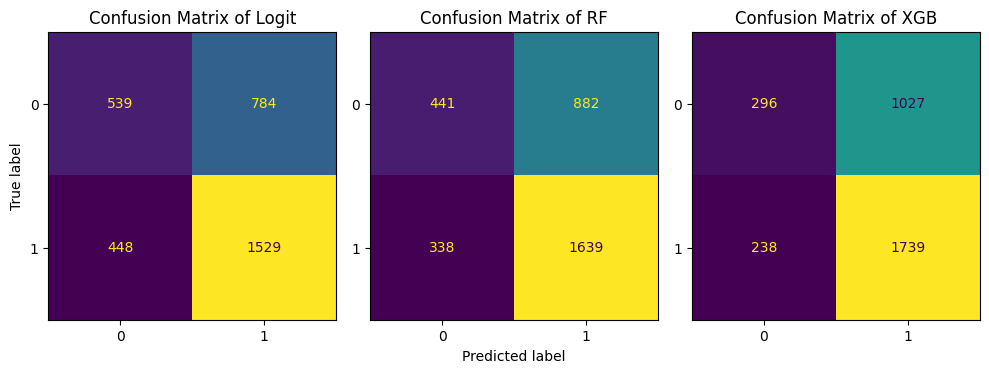

In [73]:
# Logistic Regression
lr = LogisticRegression(solver = 'liblinear', penalty = 'l2', C = 0.016900000000000002)
lr.fit(X_train, y_train)
y_pred = (lr.predict_proba(X_test)[:, 1] >= 0.48)

fig, ax = plt.subplots(1, 3, figsize = (10, 10))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels = lr.classes_), display_labels = lr.classes_).plot(ax = ax[0],
                                                                                                                  colorbar = False)
ax[0].set_title('Confusion Matrix of Logit')
ax[0].set_xlabel('')

# Random Forest
rf = RandomForestClassifier(n_estimators = 4, min_samples_split = 7, min_samples_leaf = 6,
                            max_depth = 6, criterion = 'gini', max_features = 'auto', random_state = 42)
rf.fit(X_train, y_train)
y_pred = (rf.predict_proba(X_test)[:, 1] >= 0.419)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels = rf.classes_), display_labels = rf.classes_).plot(ax = ax[1],
                                                                                                                  colorbar = False)
ax[1].set_title('Confusion Matrix of RF')
ax[1].set_ylabel('')

# XGBoost
xgb = XGBClassifier(max_depth = 2, min_child_weight = 29, gamma = 5.0, tree_method = 'exact', random_state = 42)
xgb.fit(X_train, y_train)
y_pred = (xgb.predict_proba(X_test)[:, 1] >= 0.447)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels = xgb.classes_), display_labels = xgb.classes_).plot(ax = ax[2],
                                                                                                                    colorbar = False)
ax[2].set_title('Confusion Matrix of XGB')
ax[2].set_ylabel('')
ax[2].set_xlabel('')

plt.tight_layout()

The confusion matrix shows that random forest predicts late deliveries more accurately, but at the cost of increased false positives (on-time deliveries that are predicted late) but not as much as XGBoost. This is not a major problem, because the delivery will still be on time regardless of the late prediction. The core problem is late deliveries that are predicted on time, which can make customers unhappy and less trusting of our company. Random forest does a decent job of avoiding this problem than Logistic Regression although XGBoost does this better but it produces too many False Positives.

## Feature Importance

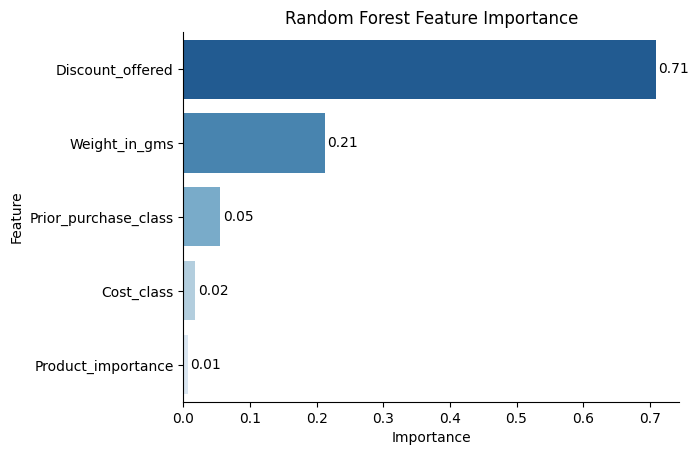

In [74]:
# Creating the feature importance dataframe
feat_imp = pd.DataFrame(rf.feature_importances_.tolist(), X.columns.tolist())\
           .reset_index(names = 'Feature').rename(columns = {0 : 'Importance'}).sort_values('Importance', ascending = False)

# Plotting feature importance on a horizontal bar chart
fig, ax = plt.subplots()
sns.barplot(ax = ax, data = feat_imp, y = 'Feature', x = 'Importance', palette = 'Blues_r')
ax.bar_label(ax.containers[0], fmt = '%.2f', padding = 2)

sns.despine(ax = ax, right = True)
ax.set_title('Random Forest Feature Importance')
plt.show()

Discount is the most important factor associated with delivery status, followed by weight. Prior purchase, cost of product, and product importance have a minor association with delivery status.

But we don't know the direction of these features towards the delivery status. For that, we're gonna use SHAP values.

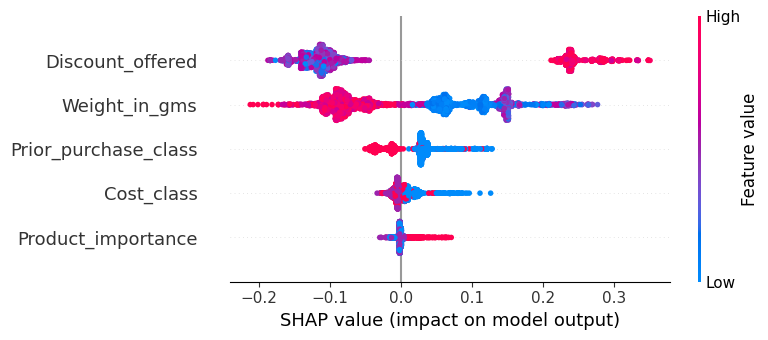

In [75]:
rf = RandomForestClassifier(n_estimators = 4, min_samples_split = 7, min_samples_leaf = 6,
                            max_depth = 6, criterion = 'gini', max_features = 'auto', random_state = 42)

rf.fit(X_train, y_train)
explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test)

Remember that a positive output (True / 1) in our dataset indicates a late delivery. Based on the summary plot above, we can infer the following:

1. Higher discounts are more likely to be associated with late deliveries. This means that the more discount an order has, the higher the probability that it will be late.
2. Lower product weights are more likely to be associated with late deliveries. This means that the lighter the weight of a product, the higher the probability that it will be late.
3. Interestingly, people with more prior purchases are slightly less likely to experience late deliveries.
4. Lower cost of products tend to be associated with late deliveries.
5. Higher product importance tend to be associated with late deliveries.

Based on these insights. We can take the following interim actions before any further analysis:
1. **Implementing a Discount Threshold Policy (to be simulated)**

    We propose to simulate the impact of setting a maximum discount threshold for orders. This policy could help balance attracting customers through discounts and ensuring on-time delivery. We will assess whether setting a discount threshold of 10% in this dataset will lead to an increase in on-time delivery rates.
    
    While this may increase on-time delivery rates, we need to investigate further why higher discounts lead to late deliveries. For this analysis, we would need more relevant data, such as detailed warehouse and logistics data. The dataset in this project is insufficient to identify the root causes of lateness at higher discount rates.

    There is a risk that some customers may lose interest if we limit discounts. We need to clarify that this limit is temporary while we investigate the causes of late deliveries at higher discount rates and develop solutions. This will make us more trustworthy by demonstrating our transparency.

    Because we are reducing discounts, we need to offer something else to customers in their place. This could be loyalty rewards, points, or early access to new products. This way, customers can still maintain their interest, albeit in a different form than discounts.

2. **Bundled Products Shipment (to be simulated)**

    One way to reduce the likelihood of late deliveries for lighter products is to bundle them together into heavier packages. For example, we could bundle several small toys together based on their region or address and count them as a single product in the logistics process. Once the bundles arrive at the local shipment warehouse, they can be unpacked.

    This process would not be visible to customers. If we have a mobile app that tracks orders, each customer's order would still appear as a single order, not mixed with other customers' orders. This is because the bundling would only occur during the logistics process until the bundles reach the local shipment warehouse.

    However, we still need to investigate the root causes of why lighter products are more likely to be late. For this, we would need the same dataset as before, including warehouse and logistics data. The dataset in this project is not sufficient to identify the causes of late deliveries for lighter products.

There is one last prescriptive recommendations for those customers who will experience late deliveries:

- **Inform customers of the delay and extend the estimated delivery date.**

    The first thing to do is to contact/inform the customer that the delivery will be delayed so that they will not be surprised if the product hasn't been delivered by the estimated delivery date. Then, we can add *x* days to the estimated delivery date to extend the range.

- **Offer incentives to customers who experience late deliveries**
    
    Because higher discount in this dataset is associated with lateness, we can offer other alternative incentives to them, such as loyalty points, free delivery on the next order, exclusive access to new product/market section, and many more. Consider offering customers the option to choose the incentive that they prefer. This will give customers more control over the situation and make them more likely to be satisfied with the outcome.

# Business Recommendation: Discount Threshold & Weight Simulation
In this section, we're going to simulate what will happen if we limit the discount and increase the weight (bundle simulation) of the shipment.

In [76]:
# Creating the simulation dataset from the original dataset
X_sim = X.copy()

# Setting the random seed for discount simulation
np.random.seed(42)

# Simulating the discount threshold of 4%
X_sim['Discount_offered'] = X_sim['Discount_offered'].apply(lambda x : np.random.randint(1, 4))
X_sim['Weight_in_gms'] = X_sim['Weight_in_gms'].apply(lambda x : np.random.randint(5000, 6000) if x < 4500 else x)
#X_sim['pp_class_enc'] = X_sim['pp_class_enc'].apply(lambda x : float(1) if x < 1.0 else x)

# Transforming the discount feature again
X_sim['Discount_offered'] = boxcox.transform(np.array(X_sim['Discount_offered']).reshape(-1, 1))

# Standardizing the rest of the features
X_sim = scaler.transform(X_sim)

# Predicting on the new simulated dataset
y_pred_sim = (rf.predict_proba(X_sim)[:, 1] >= 0.419)

# Seeing the delivery status distribution
pd.Series(y_pred_sim).value_counts(normalize = True)

False    0.57778
True     0.42222
Name: proportion, dtype: float64

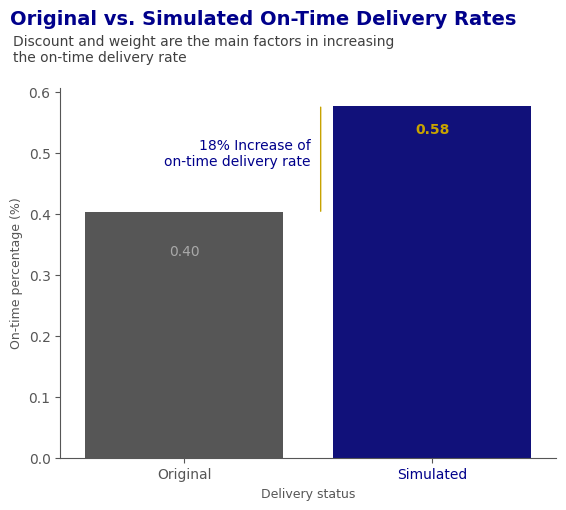

In [77]:
# Getting the original dataset delivery status distribution
original_perc = pd.Series(y_pred_sim).value_counts(normalize = True)[[0]].to_frame().reset_index()
original_perc.columns = ['Dataset', 'On-time percentage']
original_perc.iloc[0, 0] = 'Simulated'

# Getting the simulated dataset delivery status distribution
sim_perc = df['Delivery_status'].value_counts(normalize = True)[[0]].to_frame().reset_index()
sim_perc.columns = ['Dataset', 'On-time percentage']
sim_perc.iloc[0, 0] = 'Original'

# Concatenating both result from original and simulated dataset
percent = pd.concat([original_perc, sim_perc], ignore_index = True)
percent

# Creating the plot
fig, ax = plt.subplots()
sns.barplot(y = 'On-time percentage', x = 'Dataset', data = percent, order = ['Original', 'Simulated'], palette = ['#565656', 'darkblue'])
sns.despine(right = True)

# Setting bar label
barlab = ax.bar_label(ax.containers[0], c = 'black', fmt = '%.2f', label_type = 'center')
barlab[0].set(y = 60, c = 'darkgrey')
barlab[1].set(y = 110, c = '#C7A300', weight = 'bold')

# Setting spine, ticks, and label colors
ax.spines['bottom'].set_color('#565656')
ax.spines['left'].set_color('#565656')
ax.tick_params(axis='both', colors='#565656')
ax.set_xlabel('Delivery status', size = 9, c = '#565656')
ax.set_ylabel(ax.get_ylabel() + ' (%)', size = 9, c = '#565656')
ax.set_xticklabels(ax.get_xticklabels(), c = '#565656')

xtick = ax.get_xticklabels()
xtick[1].set(color = 'darkblue')

# Annotating the increase in on-time delivery rate
ax.annotate(xytext = (0.55, 0.4), xy = (0.55, 0.58), text = '', arrowprops = dict(arrowstyle = '-', color = '#C7A300'))
plt.text(s = '18% Increase of\non-time delivery rate', x = 0.51, y = 0.48, color = 'darkblue', ha = 'right')

# Inserting title and subtitle
plt.title('Original vs. Simulated On-Time Delivery Rates', weight = 'bold', c = 'darkblue', x = 0.41, y = 1.15, size = 14)
plt.text(s = 'Discount and weight are the main factors in increasing\nthe on-time delivery rate', c = '#404040', x = -0.69, y = 0.65)

plt.show()

The following are the interim solution/action that we could take based on the simulation:
1. Surprisingly, to better increase our on-time delivery rate we need to put a 4% threshold instead of 10%. After carefully reviewing the visualization of Weight vs. Delivery Status relationship, we can see that there are even some late deliveries in the 4% to 10% range.
2. We need to 'bundle' products with weight less than 5000 gr to be 5000 gr in the logistic process to increase the on-time delivery rate. Therefore, there need to be a additional shipment identifier for each bundle of the shipment later on.
3. There is one more catch: The more prior purchases that a customer has, the more likely that their delivery will be on-time. **This should be further analyzed later on because we're neglecting these new customers' delivery commitment!**